In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [3]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape(48,48,1)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))

#             X = torch.cat((X,X,X),0)

        return X, y

In [4]:
batch_size= 128

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# CLAHE preprocessing
def clahe(x):
    x = np.array(x) # unit8
    x = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    x = x.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x)
    
    return x

train_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Feature Act v4.0

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
#         self.softmax = nn.Softmax(dim=2)
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor.permute(0,3,1,2)
        cor = cor / (math.sqrt(cor.size(1)))
#         cor = self.softmax(cor)
        cor = self.att_act(cor)
        
        main_features = self.down_depth(x)
    
#         cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = torch.cat([(main_features * cor[:,:,:,k].permute(0,2,1).view(-1, self.dim, self.img_size, self.img_size)).sum(1, keepdim=True) for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4)
        self.fact1 = FeatureAct(64, 12, 4)
        self.fact2 = FeatureAct(128, 6, 4)
        self.fact3 = FeatureAct(256, 3, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv4_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.3923043012619019 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:41<00:00,  5.36it/s]

- Avg.loss: 1.653 | Avg.acc: 0.374



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.502 | Avg. val_acc: 0.463
* Update optimal model
Epoch:  2


Loss=1.3564900159835815 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 1.384 | Avg.acc: 0.489



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.318 | Avg. val_acc: 0.514
* Update optimal model
Epoch:  3


Loss=1.2427566051483154 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 1.291 | Avg.acc: 0.517



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.209 | Avg. val_acc: 0.556
* Update optimal model
Epoch:  4


Loss=1.0395488739013672 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 1.235 | Avg.acc: 0.541



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.185 | Avg. val_acc: 0.560
* Update optimal model
Epoch:  5


Loss=1.4338884353637695 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 1.188 | Avg.acc: 0.555



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.185 | Avg. val_acc: 0.553
Epoch:  6


Loss=1.1611109972000122 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 1.160 | Avg.acc: 0.563



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.129 | Avg. val_acc: 0.580
* Update optimal model
Epoch:  7


Loss=1.3845094442367554 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 1.132 | Avg.acc: 0.575



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.580
* Update optimal model
Epoch:  8


Loss=1.2351295948028564 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:42<00:00,  5.28it/s]

- Avg.loss: 1.107 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.177 | Avg. val_acc: 0.564
Epoch:  9


Loss=1.089067816734314 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.28it/s]

- Avg.loss: 1.089 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.151 | Avg. val_acc: 0.573
Epoch:  10


Loss=0.8192678093910217 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 1.070 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.605
* Update optimal model
Epoch:  11


Loss=1.031555414199829 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 1.054 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.095 | Avg. val_acc: 0.584
Epoch:  12


Loss=0.9862838983535767 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 1.041 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.611
* Update optimal model
Epoch:  13


Loss=1.2052329778671265 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 1.028 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.597
Epoch:  14


Loss=1.0742619037628174 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 1.017 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047 | Avg. val_acc: 0.608
Epoch:  15


Loss=1.3059948682785034 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:43<00:00,  5.23it/s]

- Avg.loss: 1.008 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.605
Epoch:  16


Loss=1.4792673587799072 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.991 | Avg.acc: 0.630



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.603
Epoch:  17


Loss=1.0923230648040771 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.985 | Avg.acc: 0.630



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.065 | Avg. val_acc: 0.600
Epoch:  18


Loss=0.8785480856895447 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.978 | Avg.acc: 0.634



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.043 | Avg. val_acc: 0.612
* Update optimal model
Epoch:  19


Loss=1.4296112060546875 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:42<00:00,  5.28it/s]

- Avg.loss: 0.963 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.617
* Update optimal model
Epoch:  20


Loss=1.196907639503479 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 0.955 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.625
* Update optimal model
Epoch:  21


Loss=0.8728393316268921 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.943 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.175 | Avg. val_acc: 0.557
Epoch:  22


Loss=1.1156635284423828 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.935 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.635
* Update optimal model
Epoch:  23


Loss=0.6475830674171448 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.912 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.627
Epoch:  26


Loss=0.7874987721443176 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.903 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.619
Epoch:  27


Loss=1.0717761516571045 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 0.896 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.626
Epoch:  28


Loss=1.0368443727493286 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.874 | Avg.acc: 0.674



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.621
Epoch    30: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  31


Loss=0.5738666653633118 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.807 | Avg.acc: 0.699



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.968 | Avg. val_acc: 0.639
* Update optimal model
Epoch:  32


Loss=0.7466157674789429 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:42<00:00,  5.28it/s]

- Avg.loss: 0.780 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.980 | Avg. val_acc: 0.648
* Update optimal model
Epoch:  33


Loss=0.9067676663398743 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.772 | Avg.acc: 0.714



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.646
Epoch:  34


Loss=0.7264019846916199 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 0.755 | Avg.acc: 0.721



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.646
Epoch:  35


Loss=0.810368537902832 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.744 | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.650
* Update optimal model
Epoch:  36


Loss=0.6696277856826782 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:42<00:00,  5.28it/s]

- Avg.loss: 0.732 | Avg.acc: 0.730



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.640
Epoch:  37


Loss=0.7830260992050171 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:42<00:00,  5.28it/s]

- Avg.loss: 0.720 | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.982 | Avg. val_acc: 0.651
* Update optimal model
Epoch:  38


Loss=0.5580489635467529 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.714 | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.644
Epoch:  39


Loss=0.7603817582130432 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 0.699 | Avg.acc: 0.743



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.647
Epoch    39: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  40


Loss=0.6905530095100403 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 0.652 | Avg.acc: 0.763



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.657
* Update optimal model
Epoch:  41


Loss=0.5580950379371643 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 0.625 | Avg.acc: 0.774



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.649
Epoch:  42


Loss=0.7447007894515991 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 0.612 | Avg.acc: 0.778



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.655
Epoch:  43


Loss=0.4964807331562042 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.598 | Avg.acc: 0.786



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.657
Epoch:  44


Loss=0.8130096793174744 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 0.577 | Avg.acc: 0.793



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.646
Epoch:  45


Loss=0.7424119114875793 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.573 | Avg.acc: 0.795



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.655
Epoch:  46


Loss=0.7951610684394836 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 0.560 | Avg.acc: 0.801



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.651
Epoch:  47


Loss=0.518566906452179 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 0.550 | Avg.acc: 0.803



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.051 | Avg. val_acc: 0.657
Epoch    47: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  48


Loss=0.6899614334106445 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.521 | Avg.acc: 0.816



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.657
Epoch:  49


Loss=0.6764609813690186 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.497 | Avg.acc: 0.826



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059 | Avg. val_acc: 0.656
Epoch:  50


Loss=0.5355135202407837 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 0.493 | Avg.acc: 0.829



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.071 | Avg. val_acc: 0.655
Epoch:  51


Loss=0.4540630578994751 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.486 | Avg.acc: 0.831



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072 | Avg. val_acc: 0.654
Epoch:  52


Loss=0.4392165243625641 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.467 | Avg.acc: 0.839



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.077 | Avg. val_acc: 0.654
Epoch:  53


Loss=0.47883719205856323 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 0.464 | Avg.acc: 0.839



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.657
Epoch:  54


Loss=0.34509944915771484 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.451 | Avg.acc: 0.844



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.101 | Avg. val_acc: 0.653
Epoch:  55


Loss=0.3595670163631439 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:43<00:00,  5.20it/s]

- Avg.loss: 0.450 | Avg.acc: 0.845



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.093 | Avg. val_acc: 0.662
Epoch    55: reducing learning rate of group 0 to 6.2500e-05.
* Update optimal model
Epoch:  56


Loss=0.6084481477737427 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:42<00:00,  5.25it/s]

- Avg.loss: 0.429 | Avg.acc: 0.854



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.104 | Avg. val_acc: 0.658
Epoch:  57


Loss=0.5284693837165833 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.422 | Avg.acc: 0.854



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.111 | Avg. val_acc: 0.658
Epoch:  58


Loss=0.5616280436515808 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.418 | Avg.acc: 0.858



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114 | Avg. val_acc: 0.659
Epoch:  59


Loss=0.6261966824531555 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 0.409 | Avg.acc: 0.861



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.120 | Avg. val_acc: 0.658
Epoch:  60


Loss=0.4777323305606842 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.402 | Avg.acc: 0.864



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.119 | Avg. val_acc: 0.660
Epoch:  61


Loss=0.24496124684810638 Batch_id=224 Accuracy=0.972972972972973: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 0.403 | Avg.acc: 0.862



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.656
Epoch:  62


Loss=0.4178078770637512 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.388 | Avg.acc: 0.869



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.130 | Avg. val_acc: 0.656
Epoch:  63


Loss=0.5106365084648132 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.391 | Avg.acc: 0.869



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.129 | Avg. val_acc: 0.656
Epoch    63: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  64


Loss=0.4391087591648102 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:42<00:00,  5.34it/s]

- Avg.loss: 0.379 | Avg.acc: 0.872



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.654
Epoch:  65


Loss=0.38933509588241577 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 0.372 | Avg.acc: 0.875



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.133 | Avg. val_acc: 0.653
Epoch:  66


Loss=0.35491418838500977 Batch_id=18 Accuracy=0.875:   8%|▊         | 19/225 [00:05<00:57,  3.56it/s]   


KeyboardInterrupt: 

([<matplotlib.lines.Line2D at 0x7f41bc68bd68>,
 0.6620228475898579)

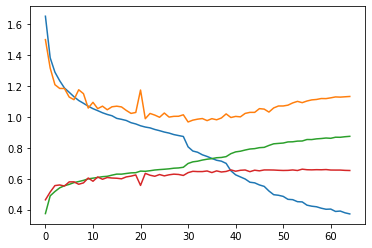

In [11]:
import pickle
pickle.dump(hist, open('featureactv4_baseline_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [10]:
test_model = torch.load('featureactv4_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.038 | Avg. val_acc: 0.668


## add more blocks

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv4b = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)
  
        self.fact0 = FeatureAct(32, 24, 4)
        self.fact1 = FeatureAct(64, 12, 4)
        self.fact2 = FeatureAct(128, 6, 4)
        self.fact3 = FeatureAct(256, 3, 4)
        self.fact4 = FeatureAct(512, 1, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = self.conv4(x3)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.conv4b(x)
        x = self.bn4b(x)
        x = self.relu(x)
        
        x4 = self.maxpool(x)
        x4 = self.fact4(x4)
        
        x = nn.Flatten()(x4)
        x = self.classifier(x)
        
        return x

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0008
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv4_baseline4blocks_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.9242236614227295 Batch_id=224 Accuracy=0.13513513513513514: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 1.939 | Avg.acc: 0.238



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.903 | Avg. val_acc: 0.249
* Update optimal model
Epoch:  2


Loss=1.8193371295928955 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 1.883 | Avg.acc: 0.254



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.863 | Avg. val_acc: 0.283
* Update optimal model
Epoch:  3


Loss=1.5955474376678467 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:02<00:00,  3.60it/s]

- Avg.loss: 1.724 | Avg.acc: 0.314



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.763 | Avg. val_acc: 0.329
* Update optimal model
Epoch:  4


Loss=1.834318995475769 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [01:02<00:00,  3.59it/s]

- Avg.loss: 1.548 | Avg.acc: 0.391



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.780 | Avg. val_acc: 0.306
Epoch:  5


Loss=1.4035993814468384 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [01:01<00:00,  3.64it/s]

- Avg.loss: 1.443 | Avg.acc: 0.440



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.377 | Avg. val_acc: 0.473
* Update optimal model
Epoch:  6


Loss=1.1894136667251587 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:01<00:00,  3.65it/s]

- Avg.loss: 1.377 | Avg.acc: 0.472



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.535 | Avg. val_acc: 0.424
Epoch:  7


Loss=1.2165085077285767 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 1.341 | Avg.acc: 0.488



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.386 | Avg. val_acc: 0.461
Epoch:  8


Loss=1.2278777360916138 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 1.298 | Avg.acc: 0.501



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.336 | Avg. val_acc: 0.486
* Update optimal model
Epoch:  9


Loss=1.4326261281967163 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:02<00:00,  3.60it/s]

- Avg.loss: 1.253 | Avg.acc: 0.521



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.257 | Avg. val_acc: 0.530
* Update optimal model
Epoch:  10


Loss=1.3221129179000854 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:02<00:00,  3.60it/s]

- Avg.loss: 1.229 | Avg.acc: 0.529



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.226 | Avg. val_acc: 0.535
* Update optimal model
Epoch:  11


Loss=1.4341344833374023 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 1.210 | Avg.acc: 0.537



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.225 | Avg. val_acc: 0.535
Epoch:  12


Loss=1.868077039718628 Batch_id=224 Accuracy=0.2972972972972973: 100%|██████████| 225/225 [01:02<00:00,  3.60it/s]

- Avg.loss: 1.193 | Avg.acc: 0.545



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.200 | Avg. val_acc: 0.549
* Update optimal model
Epoch:  13


Loss=1.3978930711746216 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 1.179 | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.229 | Avg. val_acc: 0.545
Epoch:  14


Loss=1.333658218383789 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 1.166 | Avg.acc: 0.552



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.277 | Avg. val_acc: 0.519
Epoch:  15


Loss=1.2526637315750122 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:02<00:00,  3.58it/s]

- Avg.loss: 1.147 | Avg.acc: 0.561



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.183 | Avg. val_acc: 0.547
Epoch:  16


Loss=1.0752010345458984 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:02<00:00,  3.60it/s]

- Avg.loss: 1.137 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.171 | Avg. val_acc: 0.554
* Update optimal model
Epoch:  17


Loss=1.1223385334014893 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 1.128 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.252 | Avg. val_acc: 0.555
* Update optimal model
Epoch:  18


Loss=1.220981240272522 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 1.121 | Avg.acc: 0.575



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.159 | Avg. val_acc: 0.570
* Update optimal model
Epoch:  19


Loss=1.1514559984207153 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 1.109 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.218 | Avg. val_acc: 0.548
Epoch:  20


Loss=0.9192595481872559 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:02<00:00,  3.60it/s]

- Avg.loss: 1.098 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.139 | Avg. val_acc: 0.580
* Update optimal model
Epoch:  21


Loss=0.9849824905395508 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]


- Avg.loss: 1.088 | Avg.acc: 0.591


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.130 | Avg. val_acc: 0.581
* Update optimal model
Epoch:  22


Loss=1.134087324142456 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:02<00:00,  3.57it/s]

- Avg.loss: 1.078 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.586
* Update optimal model
Epoch:  23


Loss=1.1346338987350464 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 1.075 | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.204 | Avg. val_acc: 0.550
Epoch:  24


Loss=1.0379513502120972 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 1.061 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.277 | Avg. val_acc: 0.543
Epoch:  25


Loss=1.154726505279541 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 1.051 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.586
Epoch:  26


Loss=0.7844980359077454 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:03<00:00,  3.56it/s]

- Avg.loss: 1.045 | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.237 | Avg. val_acc: 0.553
Epoch:  27


Loss=0.7987363338470459 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:01<00:00,  3.64it/s]

- Avg.loss: 1.039 | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.107 | Avg. val_acc: 0.583
Epoch:  28


Loss=0.9321314692497253 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:02<00:00,  3.63it/s]

- Avg.loss: 1.033 | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.185 | Avg. val_acc: 0.556
Epoch:  29


Loss=1.2058711051940918 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 1.019 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.127 | Avg. val_acc: 0.590
* Update optimal model
Epoch:  30


Loss=1.152321696281433 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:02<00:00,  3.60it/s]

- Avg.loss: 1.014 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.130 | Avg. val_acc: 0.580
Epoch:  31


Loss=1.0532233715057373 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:02<00:00,  3.60it/s]

- Avg.loss: 1.004 | Avg.acc: 0.628



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.118 | Avg. val_acc: 0.599
* Update optimal model
Epoch:  32


Loss=0.8229362964630127 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:02<00:00,  3.60it/s]

- Avg.loss: 0.999 | Avg.acc: 0.630



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.104 | Avg. val_acc: 0.595
Epoch:  33


Loss=1.0221084356307983 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 0.987 | Avg.acc: 0.631



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.111 | Avg. val_acc: 0.596
Epoch:  34


Loss=1.1754374504089355 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 0.986 | Avg.acc: 0.636



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.623
* Update optimal model
Epoch:  35


Loss=1.242404580116272 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:02<00:00,  3.59it/s]


- Avg.loss: 0.972 | Avg.acc: 0.641


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.065 | Avg. val_acc: 0.615
Epoch:  36


Loss=1.0450398921966553 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.972 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.190 | Avg. val_acc: 0.569
Epoch:  37


Loss=0.9225236177444458 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 0.966 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.096 | Avg. val_acc: 0.604
Epoch:  38


Loss=0.979117751121521 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:01<00:00,  3.63it/s]

- Avg.loss: 0.954 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.095 | Avg. val_acc: 0.597
Epoch:  39


Loss=1.0630594491958618 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:05<00:00,  3.44it/s]

- Avg.loss: 0.949 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.055 | Avg. val_acc: 0.618
Epoch:  40


Loss=1.1045076847076416 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]


- Avg.loss: 0.942 | Avg.acc: 0.655


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.075 | Avg. val_acc: 0.609
Epoch:  41


Loss=0.710309624671936 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.936 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.125 | Avg. val_acc: 0.611
Epoch:  42


Loss=1.1137166023254395 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 0.931 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.617
Epoch:  43


Loss=0.8825483322143555 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:02<00:00,  3.60it/s]

- Avg.loss: 0.924 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.624
* Update optimal model
Epoch:  44


Loss=1.0132800340652466 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.918 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.614
Epoch:  45


Loss=0.9878749251365662 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:02<00:00,  3.63it/s]

- Avg.loss: 0.914 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.609
Epoch:  46


Loss=1.1071590185165405 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.902 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.100 | Avg. val_acc: 0.612
Epoch:  47


Loss=1.1017557382583618 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 0.901 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.071 | Avg. val_acc: 0.630
* Update optimal model
Epoch:  48


Loss=0.7632215023040771 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.897 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.053 | Avg. val_acc: 0.626
Epoch:  49


Loss=0.7570304274559021 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.891 | Avg.acc: 0.674



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.629
Epoch:  50


Loss=1.3203028440475464 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:02<00:00,  3.63it/s]

- Avg.loss: 0.888 | Avg.acc: 0.676



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.094 | Avg. val_acc: 0.594
Epoch:  51


Loss=1.0334289073944092 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:02<00:00,  3.60it/s]

- Avg.loss: 0.882 | Avg.acc: 0.677



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.617
Epoch:  52


Loss=1.0359125137329102 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.872 | Avg.acc: 0.683



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.049 | Avg. val_acc: 0.619
Epoch:  53


Loss=1.097879409790039 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 0.868 | Avg.acc: 0.683



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.628
Epoch:  54


Loss=1.0395644903182983 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.860 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.617
Epoch:  55


Loss=0.8982111811637878 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 0.850 | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.089 | Avg. val_acc: 0.615
Epoch:  56


Loss=0.8623881340026855 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.853 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.086 | Avg. val_acc: 0.625
Epoch:  57


Loss=0.6234292387962341 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:02<00:00,  3.60it/s]

- Avg.loss: 0.844 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.618
Epoch    57: reducing learning rate of group 0 to 4.0000e-04.
Epoch:  58


Loss=0.734260082244873 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 0.801 | Avg.acc: 0.713



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.638
* Update optimal model
Epoch:  59


Loss=1.0989229679107666 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:02<00:00,  3.63it/s]

- Avg.loss: 0.772 | Avg.acc: 0.723



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.635
Epoch:  60


Loss=0.9032235145568848 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:02<00:00,  3.59it/s]

- Avg.loss: 0.758 | Avg.acc: 0.730



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.055 | Avg. val_acc: 0.626
Epoch:  61


Loss=0.6844362020492554 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.751 | Avg.acc: 0.733



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.042 | Avg. val_acc: 0.634
Epoch:  62


Loss=0.811334490776062 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 0.728 | Avg.acc: 0.743



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.641
* Update optimal model
Epoch:  65


Loss=0.6951571106910706 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.727 | Avg.acc: 0.741



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.632
Epoch:  66


Loss=0.933417558670044 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.718 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.067 | Avg. val_acc: 0.643
Epoch    66: reducing learning rate of group 0 to 2.0000e-04.
* Update optimal model
Epoch:  67


Loss=0.8475633263587952 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.677 | Avg.acc: 0.764



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.642
Epoch:  68


Loss=0.48382315039634705 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:01<00:00,  3.63it/s]

- Avg.loss: 0.665 | Avg.acc: 0.765



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.039 | Avg. val_acc: 0.644
* Update optimal model
Epoch:  69


Loss=0.45418408513069153 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.657 | Avg.acc: 0.770



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.641
Epoch:  70


Loss=0.5302605628967285 Batch_id=176 Accuracy=0.84375:  79%|███████▊  | 177/225 [00:49<00:12,  3.71it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.6883121728897095 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 0.515 | Avg.acc: 0.828



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.143 | Avg. val_acc: 0.644
Epoch:  89


Loss=0.3952437937259674 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s]

- Avg.loss: 0.514 | Avg.acc: 0.828



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.143 | Avg. val_acc: 0.648
Epoch:  90


Loss=0.6712857484817505 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.517 | Avg.acc: 0.827



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.142 | Avg. val_acc: 0.641
Epoch    90: reducing learning rate of group 0 to 2.5000e-05.
Epoch:  91


Loss=0.8508711457252502 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:02<00:00,  3.59it/s]

- Avg.loss: 0.511 | Avg.acc: 0.829



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.642
Epoch:  92


Loss=0.7241530418395996 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.505 | Avg.acc: 0.831



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.141 | Avg. val_acc: 0.646
Epoch:  93


Loss=0.381694495677948 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [01:02<00:00,  3.62it/s]

- Avg.loss: 0.502 | Avg.acc: 0.833



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.147 | Avg. val_acc: 0.640
Epoch:  94


Loss=0.5237811207771301 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [01:01<00:00,  3.63it/s]

- Avg.loss: 0.508 | Avg.acc: 0.831



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.152 | Avg. val_acc: 0.645
Epoch:  95


Loss=0.623191237449646 Batch_id=63 Accuracy=0.8125:  28%|██▊       | 63/225 [00:19<00:43,  3.73it/s]     IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



([<matplotlib.lines.Line2D at 0x7f725a013eb8>,
 0.6508776818055169)

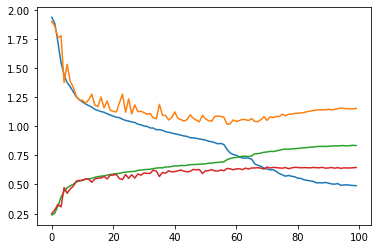

In [10]:
import pickle
pickle.dump(hist, open('featureactv4_baseline4blocks_hist.hdf5', 'wb'))
plt.plot(hist), best_acc

In [12]:
test_model = torch.load('featureactv4_baseline4blocks_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.032 | Avg. val_acc: 0.656


## v4.2

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
#         self.softmax = nn.Softmax(dim=2)
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        self.att_act = nn.Sequential(nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False),
                                     nn.Sigmoid())
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.down_depth = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
                    
        self.up_depth = nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False)
        
        self.proj_conv = nn.Sequential(nn.Conv2d(src_depth, src_depth, kernel_size=1, padding=True),
                                       nn.ReLU(inplace=True))
                                      
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor.permute(0,3,1,2)
        cor = cor / (math.sqrt(cor.size(1)))
#         cor = self.softmax(cor)
        cor = self.att_act(cor)
        
        main_features = self.down_depth(x)
    
#         cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = torch.cat([(main_features * cor[:,:,:,k].permute(0,2,1).view(-1, self.dim, self.img_size, self.img_size)).sum(1, keepdim=True) for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        
        
        return x

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4)
        self.fact1 = FeatureAct(64, 12, 4)
        self.fact2 = FeatureAct(128, 6, 4)
        self.fact3 = FeatureAct(256, 3, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv42_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.7761597633361816 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 1.754 | Avg.acc: 0.325



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.556 | Avg. val_acc: 0.419
* Update optimal model
Epoch:  2


Loss=1.4636244773864746 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 1.505 | Avg.acc: 0.431



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.365 | Avg. val_acc: 0.483
* Update optimal model
Epoch:  3


Loss=1.2941486835479736 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 1.395 | Avg.acc: 0.469



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.331 | Avg. val_acc: 0.495
* Update optimal model
Epoch:  4


Loss=1.2259441614151 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 1.325 | Avg.acc: 0.499



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.503 | Avg. val_acc: 0.424
Epoch:  5


Loss=1.3127028942108154 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 1.280 | Avg.acc: 0.518



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.365 | Avg. val_acc: 0.502
* Update optimal model
Epoch:  6


Loss=1.3711447715759277 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:42<00:00,  5.28it/s]

- Avg.loss: 1.242 | Avg.acc: 0.530



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.432 | Avg. val_acc: 0.472
Epoch:  7


Loss=1.2980923652648926 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 1.205 | Avg.acc: 0.544



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.192 | Avg. val_acc: 0.556
* Update optimal model
Epoch:  8


Loss=1.2494916915893555 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 1.180 | Avg.acc: 0.554



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.226 | Avg. val_acc: 0.540
Epoch:  9


Loss=1.1816678047180176 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 1.163 | Avg.acc: 0.561



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.155 | Avg. val_acc: 0.562
* Update optimal model
Epoch:  10


Loss=1.127145767211914 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:42<00:00,  5.25it/s]

- Avg.loss: 1.143 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.342 | Avg. val_acc: 0.509
Epoch:  11


Loss=1.0028914213180542 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.24it/s]

- Avg.loss: 1.131 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.212 | Avg. val_acc: 0.551
Epoch:  12


Loss=1.2055541276931763 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 1.117 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103 | Avg. val_acc: 0.592
* Update optimal model
Epoch:  13


Loss=1.1168782711029053 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 1.094 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.145 | Avg. val_acc: 0.571
Epoch:  14


Loss=1.2460336685180664 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:43<00:00,  5.22it/s]

- Avg.loss: 1.089 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.119 | Avg. val_acc: 0.583
Epoch:  15


Loss=1.1200251579284668 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:43<00:00,  5.20it/s]

- Avg.loss: 1.078 | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.105 | Avg. val_acc: 0.587
Epoch:  16


Loss=1.0079610347747803 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 1.070 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.583
Epoch:  17


Loss=1.1119450330734253 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 1.051 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.099 | Avg. val_acc: 0.590
Epoch:  18


Loss=1.1591687202453613 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 1.051 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.602
* Update optimal model
Epoch:  19


Loss=1.267838478088379 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 1.034 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.097 | Avg. val_acc: 0.589
Epoch:  20


Loss=1.0266653299331665 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 1.024 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.605
* Update optimal model
Epoch:  21


Loss=1.0506656169891357 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 1.017 | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.146 | Avg. val_acc: 0.569
Epoch:  22


Loss=0.7156949639320374 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 1.010 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.585
Epoch:  23


Loss=0.9531368613243103 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 1.005 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.614
* Update optimal model
Epoch:  24


Loss=1.051753282546997 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 0.992 | Avg.acc: 0.629



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.602
Epoch:  25


Loss=0.888824999332428 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 0.983 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.152 | Avg. val_acc: 0.580
Epoch:  26


Loss=1.0842835903167725 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 0.988 | Avg.acc: 0.626



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.065 | Avg. val_acc: 0.603
Epoch:  27


Loss=0.9435529708862305 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 0.967 | Avg.acc: 0.636



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.615
* Update optimal model
Epoch:  28


Loss=0.8750547170639038 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:42<00:00,  5.25it/s]

- Avg.loss: 0.964 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.599
Epoch:  29


Loss=0.9922383427619934 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.962 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059 | Avg. val_acc: 0.609
Epoch:  30


Loss=1.0282721519470215 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.947 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.071 | Avg. val_acc: 0.603
Epoch:  31


Loss=1.1303071975708008 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.944 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.043 | Avg. val_acc: 0.619
Epoch    31: reducing learning rate of group 0 to 5.0000e-04.
* Update optimal model
Epoch:  32


Loss=1.1808192729949951 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 0.891 | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.630
* Update optimal model
Epoch:  33


Loss=0.9234254956245422 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.883 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.628
Epoch:  34


Loss=1.0151416063308716 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.28it/s]

- Avg.loss: 0.868 | Avg.acc: 0.676



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.635
* Update optimal model
Epoch:  35


Loss=0.8252168297767639 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.853 | Avg.acc: 0.687



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.982 | Avg. val_acc: 0.634
Epoch:  36


Loss=0.9741162657737732 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.25it/s]

- Avg.loss: 0.846 | Avg.acc: 0.683



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.632
Epoch:  37


Loss=0.9540857672691345 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.28it/s]

- Avg.loss: 0.841 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.981 | Avg. val_acc: 0.638
* Update optimal model
Epoch:  38


Loss=0.6673025488853455 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 0.837 | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.633
Epoch:  39


Loss=1.0081416368484497 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.823 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033 | Avg. val_acc: 0.627
Epoch:  40


Loss=0.8362811207771301 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 0.820 | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.631
Epoch:  41


Loss=1.1834595203399658 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.812 | Avg.acc: 0.700



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.633
Epoch:  42


Loss=0.9140697121620178 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 0.800 | Avg.acc: 0.705



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.636
Epoch:  43


Loss=0.704217255115509 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.801 | Avg.acc: 0.704



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.634
Epoch:  44


Loss=1.0641307830810547 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.25it/s]

- Avg.loss: 0.787 | Avg.acc: 0.709



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.638
Epoch:  45


Loss=0.7377481460571289 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:42<00:00,  5.25it/s]

- Avg.loss: 0.786 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.640
Epoch    45: reducing learning rate of group 0 to 2.5000e-04.
* Update optimal model
Epoch:  46


Loss=0.6723626852035522 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 0.743 | Avg.acc: 0.728



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.638
Epoch:  47


Loss=1.1424638032913208 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 0.732 | Avg.acc: 0.735



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.652
* Update optimal model
Epoch:  48


Loss=0.6525701284408569 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.720 | Avg.acc: 0.739



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.645
Epoch:  49


Loss=0.6034425497055054 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 0.714 | Avg.acc: 0.741



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.652
Epoch:  50


Loss=0.6387441754341125 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 0.703 | Avg.acc: 0.742



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.653
* Update optimal model
Epoch:  51


Loss=0.9347597360610962 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 0.697 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.647
Epoch:  52


Loss=0.9234817028045654 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.693 | Avg.acc: 0.749



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.648
Epoch:  53


Loss=0.8121956586837769 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.681 | Avg.acc: 0.754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.642
Epoch    53: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  54


Loss=0.6959425210952759 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:42<00:00,  5.28it/s]

- Avg.loss: 0.655 | Avg.acc: 0.768



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.650
Epoch:  55


Loss=0.6448732018470764 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.646 | Avg.acc: 0.769



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.012 | Avg. val_acc: 0.653
Epoch:  56


Loss=0.6292441487312317 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 0.631 | Avg.acc: 0.773



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.648
Epoch:  57


Loss=1.0169416666030884 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.627 | Avg.acc: 0.775



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.650
Epoch:  58


Loss=0.6470964550971985 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 0.615 | Avg.acc: 0.779



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027 | Avg. val_acc: 0.652
Epoch:  61


Loss=0.8793736100196838 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:42<00:00,  5.24it/s]

- Avg.loss: 0.604 | Avg.acc: 0.783



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.049 | Avg. val_acc: 0.647
Epoch    61: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  62


Loss=0.654078483581543 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.591 | Avg.acc: 0.791



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.043 | Avg. val_acc: 0.648
Epoch:  63


Loss=0.5586995482444763 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:42<00:00,  5.28it/s]

- Avg.loss: 0.587 | Avg.acc: 0.793



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.046 | Avg. val_acc: 0.644
Epoch:  64


Loss=0.5046715140342712 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:42<00:00,  5.25it/s]

- Avg.loss: 0.579 | Avg.acc: 0.796



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047 | Avg. val_acc: 0.645
Epoch:  65


Loss=0.5318333506584167 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:42<00:00,  5.28it/s]

- Avg.loss: 0.571 | Avg.acc: 0.799



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.048 | Avg. val_acc: 0.646
Epoch:  66


Loss=0.7952315807342529 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 0.569 | Avg.acc: 0.797



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.051 | Avg. val_acc: 0.646
Epoch:  67


Loss=0.49233922362327576 Batch_id=42 Accuracy=0.84375:  19%|█▉        | 43/225 [00:09<00:34,  5.24it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.5003622174263 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:42<00:00,  5.25it/s]

- Avg.loss: 0.558 | Avg.acc: 0.803



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.646
Epoch    69: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  70


Loss=0.41242727637290955 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:42<00:00,  5.24it/s]

- Avg.loss: 0.553 | Avg.acc: 0.806



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.651
Epoch:  71


Loss=0.8958083391189575 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:42<00:00,  5.24it/s]

- Avg.loss: 0.549 | Avg.acc: 0.806



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.060 | Avg. val_acc: 0.648
Epoch:  72


Loss=0.6509402394294739 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.548 | Avg.acc: 0.805



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.645
Epoch:  73


Loss=0.9840753078460693 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.543 | Avg.acc: 0.812



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.063 | Avg. val_acc: 0.651
Epoch:  74


Loss=0.5280066132545471 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 0.534 | Avg.acc: 0.811



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.061 | Avg. val_acc: 0.649
Epoch:  75


Loss=0.8445959091186523 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 0.538 | Avg.acc: 0.810



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.652
Epoch:  76


Loss=0.5469386577606201 Batch_id=142 Accuracy=0.8125:  64%|██████▎   | 143/225 [00:28<00:16,  5.07it/s]    


KeyboardInterrupt: 

([<matplotlib.lines.Line2D at 0x7fc51c991128>,
 0.6533853441069936)

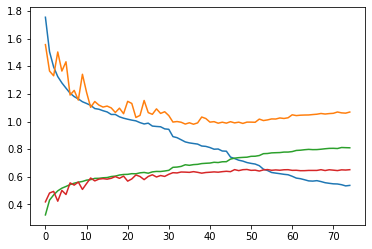

In [10]:
import pickle
pickle.dump(hist, open('featureactv42_baseline_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [12]:
test_model = torch.load('featureactv42_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 0.977 | Avg. val_acc: 0.647


## v4.1 add normalization after CAM operation

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
#         self.softmax = nn.Softmax(dim=2)
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor.permute(0,3,1,2)
        cor = cor / (math.sqrt(cor.size(1)))
#         cor = self.softmax(cor)
        cor = self.att_act(cor)
        
        main_features = self.down_depth(x)
    
#         cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = torch.cat([((main_features * cor[:,:,:,k].permute(0,2,1).view(-1, self.dim, self.img_size, self.img_size)).sum(1, keepdim=True) / self.dim) for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4)
        self.fact1 = FeatureAct(64, 12, 4)
        self.fact2 = FeatureAct(128, 6, 4)
        self.fact3 = FeatureAct(256, 3, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [8]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [9]:
model_path = './featureactv41_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.6376147270202637 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:44<00:00,  5.11it/s]

- Avg.loss: 1.623 | Avg.acc: 0.393



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.417 | Avg. val_acc: 0.479
* Update optimal model
Epoch:  2


Loss=1.1486804485321045 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:43<00:00,  5.14it/s]

- Avg.loss: 1.371 | Avg.acc: 0.490



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.287 | Avg. val_acc: 0.535
* Update optimal model
Epoch:  3


Loss=1.3751802444458008 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:43<00:00,  5.12it/s]

- Avg.loss: 1.281 | Avg.acc: 0.525



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.296 | Avg. val_acc: 0.525
Epoch:  4


Loss=0.9828671813011169 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:44<00:00,  5.11it/s]

- Avg.loss: 1.228 | Avg.acc: 0.542



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.214 | Avg. val_acc: 0.547
* Update optimal model
Epoch:  5


Loss=1.1168665885925293 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:44<00:00,  5.08it/s]

- Avg.loss: 1.186 | Avg.acc: 0.557



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.195 | Avg. val_acc: 0.555
* Update optimal model
Epoch:  6


Loss=1.282058596611023 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:43<00:00,  5.13it/s]

- Avg.loss: 1.154 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.157 | Avg. val_acc: 0.564
* Update optimal model
Epoch:  7


Loss=1.1623382568359375 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 1.129 | Avg.acc: 0.577



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.115 | Avg. val_acc: 0.578
* Update optimal model
Epoch:  8


Loss=1.1470577716827393 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:44<00:00,  5.09it/s]

- Avg.loss: 1.107 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.120 | Avg. val_acc: 0.576
Epoch:  9


Loss=0.9385504722595215 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:44<00:00,  5.09it/s]

- Avg.loss: 1.083 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090 | Avg. val_acc: 0.588
* Update optimal model
Epoch:  10


Loss=1.0249969959259033 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:44<00:00,  5.08it/s]

- Avg.loss: 1.069 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.578
Epoch:  11


Loss=0.9429311156272888 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:44<00:00,  5.05it/s]

- Avg.loss: 1.056 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.082 | Avg. val_acc: 0.592
* Update optimal model
Epoch:  12


Loss=0.9210466742515564 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 1.046 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.061 | Avg. val_acc: 0.605
* Update optimal model
Epoch:  13


Loss=0.9366396069526672 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:43<00:00,  5.12it/s]

- Avg.loss: 1.027 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.121 | Avg. val_acc: 0.586
Epoch:  14


Loss=0.8595441579818726 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 1.018 | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.597
Epoch:  15


Loss=1.118411898612976 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:44<00:00,  5.09it/s]

- Avg.loss: 1.001 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.611
* Update optimal model
Epoch:  16


Loss=1.1204020977020264 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:43<00:00,  5.13it/s]

- Avg.loss: 0.992 | Avg.acc: 0.628



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.043 | Avg. val_acc: 0.608
Epoch:  17


Loss=1.121705412864685 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:44<00:00,  5.09it/s]

- Avg.loss: 0.981 | Avg.acc: 0.633



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.120 | Avg. val_acc: 0.586
Epoch:  18


Loss=0.9671491384506226 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:44<00:00,  5.08it/s]

- Avg.loss: 0.971 | Avg.acc: 0.636



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.616
* Update optimal model
Epoch:  19


Loss=1.0260822772979736 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:44<00:00,  5.08it/s]

- Avg.loss: 0.963 | Avg.acc: 0.640



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.626
* Update optimal model
Epoch:  20


Loss=0.8874544501304626 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 0.947 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033 | Avg. val_acc: 0.615
Epoch:  21


Loss=1.0954525470733643 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:43<00:00,  5.17it/s]

- Avg.loss: 0.941 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.614
Epoch:  22


Loss=1.5375462770462036 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 0.933 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.619
Epoch:  23


Loss=1.0855915546417236 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:43<00:00,  5.13it/s]

- Avg.loss: 0.923 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056 | Avg. val_acc: 0.614
Epoch:  24


Loss=1.1273066997528076 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:43<00:00,  5.14it/s]

- Avg.loss: 0.914 | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.625
Epoch:  25


Loss=0.7941728234291077 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 0.906 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.623
Epoch:  26


Loss=0.8973418474197388 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:44<00:00,  5.11it/s]

- Avg.loss: 0.898 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.635
* Update optimal model
Epoch:  27


Loss=0.8303270936012268 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:44<00:00,  5.09it/s]

- Avg.loss: 0.889 | Avg.acc: 0.668



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.630
Epoch:  28


Loss=0.7156534790992737 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:43<00:00,  5.15it/s]

- Avg.loss: 0.878 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.622
Epoch:  29


Loss=0.8872888088226318 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 0.872 | Avg.acc: 0.675



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.611
Epoch:  30


Loss=0.9699735641479492 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 0.872 | Avg.acc: 0.675



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.627
Epoch:  31


Loss=0.9784982204437256 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:44<00:00,  5.11it/s]

- Avg.loss: 0.855 | Avg.acc: 0.679



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.628
Epoch:  32


Loss=0.9479470252990723 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 0.850 | Avg.acc: 0.682



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.629
Epoch:  33


Loss=0.8184604048728943 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 0.842 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.008 | Avg. val_acc: 0.630
Epoch:  34


Loss=0.8675147294998169 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:43<00:00,  5.14it/s]

- Avg.loss: 0.832 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.629
Epoch    34: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  35


Loss=0.6125298142433167 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:43<00:00,  5.14it/s]

- Avg.loss: 0.766 | Avg.acc: 0.717



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.641
* Update optimal model
Epoch:  36


Loss=0.8876181840896606 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:44<00:00,  5.03it/s]

- Avg.loss: 0.739 | Avg.acc: 0.728



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.980 | Avg. val_acc: 0.648
* Update optimal model
Epoch:  37


Loss=0.7685338854789734 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:44<00:00,  5.07it/s]

- Avg.loss: 0.723 | Avg.acc: 0.733



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.648
* Update optimal model
Epoch:  38


Loss=0.7217859029769897 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 0.712 | Avg.acc: 0.737



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.650
* Update optimal model
Epoch:  39


Loss=0.8380380272865295 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:44<00:00,  5.09it/s]

- Avg.loss: 0.697 | Avg.acc: 0.744



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.646
Epoch:  40


Loss=0.5277417898178101 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:43<00:00,  5.13it/s]

- Avg.loss: 0.687 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.642
Epoch:  41


Loss=0.9479090571403503 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:44<00:00,  5.08it/s]

- Avg.loss: 0.678 | Avg.acc: 0.755



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.647
Epoch:  42


Loss=0.517645537853241 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:44<00:00,  5.09it/s]

- Avg.loss: 0.668 | Avg.acc: 0.757



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.648
Epoch:  43


Loss=0.6473006010055542 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:43<00:00,  5.13it/s]

- Avg.loss: 0.657 | Avg.acc: 0.762



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.649
Epoch:  44


Loss=0.5898169279098511 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:44<00:00,  5.09it/s]

- Avg.loss: 0.641 | Avg.acc: 0.768



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.654
* Update optimal model
Epoch:  45


Loss=0.5848045349121094 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:43<00:00,  5.13it/s]

- Avg.loss: 0.630 | Avg.acc: 0.771



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.649
Epoch:  46


Loss=0.7146977782249451 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:44<00:00,  5.11it/s]

- Avg.loss: 0.620 | Avg.acc: 0.772



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.653
Epoch    46: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  47


Loss=0.6116511821746826 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:43<00:00,  5.12it/s]

- Avg.loss: 0.569 | Avg.acc: 0.796



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.667
* Update optimal model
Epoch:  48


Loss=0.4265122711658478 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:43<00:00,  5.13it/s]

- Avg.loss: 0.538 | Avg.acc: 0.807



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.663
Epoch:  49


Loss=0.4246786832809448 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 0.529 | Avg.acc: 0.811



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.039 | Avg. val_acc: 0.661
Epoch:  50


Loss=0.5291602611541748 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:44<00:00,  5.09it/s]

- Avg.loss: 0.510 | Avg.acc: 0.821



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.655
Epoch:  51


Loss=1.0744469165802002 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:43<00:00,  5.13it/s]

- Avg.loss: 0.506 | Avg.acc: 0.822



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.657
Epoch:  52


Loss=0.4258768856525421 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:44<00:00,  5.11it/s]

- Avg.loss: 0.484 | Avg.acc: 0.829



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.653
Epoch:  53


Loss=0.3925796151161194 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:43<00:00,  5.14it/s]

- Avg.loss: 0.478 | Avg.acc: 0.832



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.658
Epoch:  54


Loss=0.5340143442153931 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:43<00:00,  5.12it/s]

- Avg.loss: 0.471 | Avg.acc: 0.834



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.653
Epoch    54: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  55


Loss=0.5327767729759216 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 0.435 | Avg.acc: 0.850



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.657
Epoch:  56


Loss=0.5342799425125122 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 0.422 | Avg.acc: 0.856



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.659
Epoch:  59


Loss=0.6519200801849365 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:44<00:00,  5.08it/s]

- Avg.loss: 0.402 | Avg.acc: 0.863



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.095 | Avg. val_acc: 0.649
Epoch:  60


Loss=0.3421601355075836 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 0.383 | Avg.acc: 0.872



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.095 | Avg. val_acc: 0.652
Epoch:  61


Loss=0.5285064578056335 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:44<00:00,  5.09it/s]

- Avg.loss: 0.377 | Avg.acc: 0.874



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.117 | Avg. val_acc: 0.657
Epoch:  62


Loss=0.3625580966472626 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:43<00:00,  5.13it/s]

- Avg.loss: 0.371 | Avg.acc: 0.876



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.122 | Avg. val_acc: 0.654
Epoch    62: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  63


Loss=0.2779408395290375 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:43<00:00,  5.15it/s]

- Avg.loss: 0.353 | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.122 | Avg. val_acc: 0.650
Epoch:  64


Loss=0.480237752199173 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:43<00:00,  5.14it/s]

- Avg.loss: 0.347 | Avg.acc: 0.885



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.132 | Avg. val_acc: 0.653
Epoch:  65


Loss=0.26618242263793945 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 0.337 | Avg.acc: 0.891



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.127 | Avg. val_acc: 0.651
Epoch:  66


Loss=0.5211744904518127 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:43<00:00,  5.14it/s]

- Avg.loss: 0.333 | Avg.acc: 0.890



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.644
Epoch:  67


Loss=0.43192997574806213 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:44<00:00,  5.09it/s]

- Avg.loss: 0.330 | Avg.acc: 0.892



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.145 | Avg. val_acc: 0.652
Epoch:  68


Loss=0.34862616658210754 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:44<00:00,  5.09it/s]

- Avg.loss: 0.328 | Avg.acc: 0.891



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.149 | Avg. val_acc: 0.649
Epoch:  69


Loss=0.4427633583545685 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]

- Avg.loss: 0.322 | Avg.acc: 0.896



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.652
Epoch:  70


Loss=0.4176511764526367 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:43<00:00,  5.12it/s]

- Avg.loss: 0.320 | Avg.acc: 0.897



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.152 | Avg. val_acc: 0.649
Epoch    70: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  71


Loss=0.21909365057945251 Batch_id=58 Accuracy=0.9375:  26%|██▌       | 59/225 [00:13<00:36,  4.50it/s]   


KeyboardInterrupt: 

([<matplotlib.lines.Line2D at 0x7f68b6db8cf8>,
 0.6670381721928114)

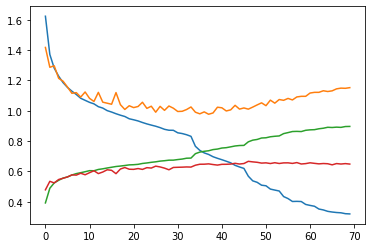

In [10]:
import pickle

pickle.dump(hist, open('featureactv41_baseline_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [11]:
test_model = torch.load('featureactv41_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.008 | Avg. val_acc: 0.670


### Test removing the last fact

In [12]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4)
        self.fact1 = FeatureAct(64, 12, 4)
        self.fact2 = FeatureAct(128, 6, 4)
#         self.fact3 = FeatureAct(256, 3, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
#         x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [13]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [16]:
model_path = './test_remove_last_fact_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.3083399534225464 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 1.636 | Avg.acc: 0.384



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.490 | Avg. val_acc: 0.464
* Update optimal model
Epoch:  2


Loss=1.207443356513977 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 1.362 | Avg.acc: 0.496



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.304 | Avg. val_acc: 0.521
* Update optimal model
Epoch:  3


Loss=1.3894776105880737 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 1.273 | Avg.acc: 0.527



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.243 | Avg. val_acc: 0.539
* Update optimal model
Epoch:  4


Loss=1.2141577005386353 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 1.213 | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.175 | Avg. val_acc: 0.566
* Update optimal model
Epoch:  5


Loss=1.8165701627731323 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 1.177 | Avg.acc: 0.558



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.201 | Avg. val_acc: 0.547
Epoch:  6


Loss=1.154712200164795 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 1.147 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.171 | Avg. val_acc: 0.547
Epoch:  7


Loss=1.168662667274475 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 1.121 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.155 | Avg. val_acc: 0.579
* Update optimal model
Epoch:  8


Loss=1.171916127204895 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 1.095 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.580
* Update optimal model
Epoch:  9


Loss=0.8834662437438965 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 1.082 | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.603
* Update optimal model
Epoch:  10


Loss=1.2647602558135986 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 1.065 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.097 | Avg. val_acc: 0.590
Epoch:  11


Loss=1.1006656885147095 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 1.049 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.065 | Avg. val_acc: 0.604
* Update optimal model
Epoch:  12


Loss=1.0056281089782715 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 1.034 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.599
Epoch:  13


Loss=1.2429187297821045 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 1.025 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.603
Epoch:  14


Loss=0.9298046231269836 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 1.007 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.593
Epoch:  15


Loss=0.7757326364517212 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 1.000 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072 | Avg. val_acc: 0.597
Epoch:  16


Loss=1.1458356380462646 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.982 | Avg.acc: 0.630



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.049 | Avg. val_acc: 0.605
* Update optimal model
Epoch:  17


Loss=0.7675180435180664 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.972 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.605
* Update optimal model
Epoch:  18


Loss=1.1539745330810547 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.966 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.062 | Avg. val_acc: 0.609
* Update optimal model
Epoch:  19


Loss=0.8423765301704407 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.956 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.049 | Avg. val_acc: 0.609
* Update optimal model
Epoch:  20


Loss=0.9716373085975647 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.943 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.043 | Avg. val_acc: 0.621
* Update optimal model
Epoch:  21


Loss=1.0576533079147339 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.934 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.617
Epoch:  22


Loss=0.8658026456832886 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.925 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072 | Avg. val_acc: 0.603
Epoch:  23


Loss=0.789345383644104 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.913 | Avg.acc: 0.657



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.606
Epoch:  24


Loss=1.126882791519165 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.905 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.627
* Update optimal model
Epoch:  25


Loss=0.976100742816925 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 0.902 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047 | Avg. val_acc: 0.613
Epoch:  26


Loss=0.6978758573532104 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.894 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.005 | Avg. val_acc: 0.627
Epoch:  27


Loss=0.8908944129943848 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.884 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.622
Epoch:  28


Loss=0.807013750076294 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.876 | Avg.acc: 0.673



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.039 | Avg. val_acc: 0.622
Epoch:  29


Loss=1.1419742107391357 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.862 | Avg.acc: 0.679



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.609
Epoch:  30


Loss=1.01984441280365 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.859 | Avg.acc: 0.679



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.630
* Update optimal model
Epoch:  31


Loss=1.0859737396240234 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 0.851 | Avg.acc: 0.681



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.629
Epoch:  32


Loss=0.8518427610397339 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.845 | Avg.acc: 0.683



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.628
Epoch:  33


Loss=0.7053288221359253 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.831 | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.013 | Avg. val_acc: 0.631
* Update optimal model
Epoch:  34


Loss=0.8111650347709656 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.825 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.631
* Update optimal model
Epoch:  35


Loss=1.5308935642242432 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.820 | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.062 | Avg. val_acc: 0.620
Epoch:  36


Loss=0.9676729440689087 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]

- Avg.loss: 0.820 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.005 | Avg. val_acc: 0.629
Epoch:  37


Loss=0.8101828694343567 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.804 | Avg.acc: 0.699



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.620
Epoch:  38


Loss=1.1501483917236328 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 0.796 | Avg.acc: 0.704



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.633
* Update optimal model
Epoch:  39


Loss=0.9648411870002747 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.787 | Avg.acc: 0.707



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.626
Epoch:  40


Loss=0.8751708269119263 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.781 | Avg.acc: 0.713



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027 | Avg. val_acc: 0.640
* Update optimal model
Epoch:  41


Loss=0.6855461597442627 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:29<00:00,  7.62it/s]

- Avg.loss: 0.774 | Avg.acc: 0.714



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.627
Epoch:  42


Loss=1.3880454301834106 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.762 | Avg.acc: 0.718



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.645
Epoch    42: reducing learning rate of group 0 to 5.0000e-04.
* Update optimal model
Epoch:  43


Loss=0.6518495678901672 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.699 | Avg.acc: 0.744



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.642
Epoch:  44


Loss=0.7714735865592957 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]

- Avg.loss: 0.667 | Avg.acc: 0.755



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.992 | Avg. val_acc: 0.657
* Update optimal model
Epoch:  45


Loss=0.6768861413002014 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.647 | Avg.acc: 0.762



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.649
Epoch:  46


Loss=0.44236668944358826 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.634 | Avg.acc: 0.770



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.658
* Update optimal model
Epoch:  47


Loss=0.5794473886489868 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.627 | Avg.acc: 0.769



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.637
Epoch:  48


Loss=0.5187079906463623 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.608 | Avg.acc: 0.780



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.654
Epoch:  49


Loss=0.8554649949073792 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]

- Avg.loss: 0.603 | Avg.acc: 0.782



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038 | Avg. val_acc: 0.641
Epoch:  50


Loss=0.5500408411026001 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.591 | Avg.acc: 0.789



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047 | Avg. val_acc: 0.651
Epoch    50: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  51


Loss=0.6811529397964478 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.532 | Avg.acc: 0.810



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.667
* Update optimal model
Epoch:  52


Loss=0.7186655402183533 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.512 | Avg.acc: 0.818



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.665
Epoch:  53


Loss=0.7226300835609436 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.495 | Avg.acc: 0.826



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.055 | Avg. val_acc: 0.664
Epoch:  54


Loss=0.7096961140632629 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.484 | Avg.acc: 0.828



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059 | Avg. val_acc: 0.658
Epoch:  55


Loss=0.5136762261390686 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.469 | Avg.acc: 0.834



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079 | Avg. val_acc: 0.655
Epoch:  56


Loss=0.4324146807193756 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.461 | Avg.acc: 0.839



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088 | Avg. val_acc: 0.653
Epoch:  57


Loss=0.3253800868988037 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.456 | Avg.acc: 0.841



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.652
Epoch:  58


Loss=0.4401187002658844 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.389 | Avg.acc: 0.866



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.109 | Avg. val_acc: 0.655
Epoch:  62


Loss=0.37650784850120544 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.383 | Avg.acc: 0.870



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.110 | Avg. val_acc: 0.660
Epoch:  63


Loss=0.2892955243587494 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.371 | Avg.acc: 0.876



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114 | Avg. val_acc: 0.656
Epoch:  64


Loss=0.6566342711448669 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.368 | Avg.acc: 0.876



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.137 | Avg. val_acc: 0.660
Epoch:  65


Loss=0.47466200590133667 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.349 | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.138 | Avg. val_acc: 0.663
Epoch:  66


Loss=0.7585302591323853 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.352 | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.137 | Avg. val_acc: 0.655
Epoch    66: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  67


Loss=0.30579787492752075 Batch_id=213 Accuracy=0.921875:  95%|█████████▌| 214/225 [00:28<00:01,  8.73it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.659
Epoch:  73


Loss=0.3802562952041626 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.308 | Avg.acc: 0.899



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.154 | Avg. val_acc: 0.660
Epoch:  74


Loss=0.4396706223487854 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.301 | Avg.acc: 0.900



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.158 | Avg. val_acc: 0.661
Epoch    74: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  75


Loss=0.24808961153030396 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.292 | Avg.acc: 0.905



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.154 | Avg. val_acc: 0.664
Epoch:  76


Loss=0.23869352042675018 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.295 | Avg.acc: 0.904



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.167 | Avg. val_acc: 0.662
Epoch:  77


Loss=0.2875593900680542 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.292 | Avg.acc: 0.905



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.166 | Avg. val_acc: 0.664
Epoch:  78


Loss=0.31894680857658386 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.284 | Avg.acc: 0.909



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.170 | Avg. val_acc: 0.661
Epoch:  79


Loss=0.4541647732257843 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.283 | Avg.acc: 0.909



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.173 | Avg. val_acc: 0.666
Epoch:  80


Loss=0.3736312687397003 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.276 | Avg.acc: 0.912



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.160 | Avg. val_acc: 0.666
Epoch:  81


Loss=0.27859967947006226 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.282 | Avg.acc: 0.909



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.178 | Avg. val_acc: 0.666
Epoch:  82


Loss=0.4234336018562317 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.283 | Avg.acc: 0.908



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.161 | Avg. val_acc: 0.664
Epoch    82: reducing learning rate of group 0 to 1.5625e-05.
Epoch:  83


Loss=0.342464417219162 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.275 | Avg.acc: 0.911



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.165 | Avg. val_acc: 0.667
Epoch:  84


Loss=0.2554841637611389 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.268 | Avg.acc: 0.915



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.166 | Avg. val_acc: 0.667
Epoch:  85


Loss=0.27043417096138 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.269 | Avg.acc: 0.916



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.161 | Avg. val_acc: 0.667
Epoch:  86


Loss=0.2169872522354126 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.272 | Avg.acc: 0.913



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.168 | Avg. val_acc: 0.668
* Update optimal model
Epoch:  87


Loss=0.511315643787384 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.268 | Avg.acc: 0.914



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.186 | Avg. val_acc: 0.669
* Update optimal model
Epoch:  88


Loss=0.3129591643810272 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.266 | Avg.acc: 0.916



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.171 | Avg. val_acc: 0.667
Epoch:  89


Loss=0.4283813238143921 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.268 | Avg.acc: 0.917



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.185 | Avg. val_acc: 0.665
Epoch:  90


Loss=0.4795701801776886 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.263 | Avg.acc: 0.917



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.186 | Avg. val_acc: 0.663
Epoch    90: reducing learning rate of group 0 to 7.8125e-06.
Epoch:  91


Loss=0.23090119659900665 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.262 | Avg.acc: 0.918



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.175 | Avg. val_acc: 0.666
Epoch:  92


Loss=0.25096794962882996 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.263 | Avg.acc: 0.918



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.175 | Avg. val_acc: 0.666
Epoch:  93


Loss=0.21749228239059448 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.265 | Avg.acc: 0.919



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.184 | Avg. val_acc: 0.662
Epoch:  94


Loss=0.25104227662086487 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.262 | Avg.acc: 0.918



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.170 | Avg. val_acc: 0.666
Epoch:  95


Loss=0.23302441835403442 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.266 | Avg.acc: 0.913



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.173 | Avg. val_acc: 0.666
Epoch:  96


Loss=0.11725211888551712 Batch_id=224 Accuracy=0.972972972972973: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.258 | Avg.acc: 0.919



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.186 | Avg. val_acc: 0.665
Epoch:  100


Loss=0.1887814700603485 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.260 | Avg.acc: 0.917


- Avg. val_loss: 1.180 | Avg. val_acc: 0.665
Finished Training


## v4 whatever

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1, dropout=0.):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        
        self.dropout = nn.Dropout(dropout)
        
        self.layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        self.norm_conv = nn.Sequential(nn.Conv2d(self.dim, self.dim, kernel_size=1, padding=False),
                                       nn.Dropout(dropout))
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        x_norm = self.layernorm(x)
        src_features = self.src_conv(x_norm)
        target_features = self.target_conv(x_norm)
        main_features = self.down_depth(x_norm)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor.permute(0,3,1,2)
        cor = cor / (math.sqrt(cor.size(1)))
        cor = self.att_act(cor)
        cor = self.dropout(cor) # additional dropout to prevent overfitting
    
        cor_feature = torch.cat([(main_features * self.norm_conv(cor[:,:,:,k].permute(0,2,1).view(-1, self.dim, self.img_size, self.img_size))).sum(1, keepdim=True) for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4, dropout=0.4)
        self.fact1 = FeatureAct(64, 12, 4, dropout=0.4)
        self.fact2 = FeatureAct(128, 6, 4, dropout=0.4)
        self.fact3 = FeatureAct(256, 3, 4, dropout=0.4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [8]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [9]:
model_path = './featureactv4_whatever_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.2597564458847046 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:53<00:00,  4.24it/s]

- Avg.loss: 1.623 | Avg.acc: 0.390



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.434 | Avg. val_acc: 0.466
* Update optimal model
Epoch:  2


Loss=1.2781141996383667 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

- Avg.loss: 1.366 | Avg.acc: 0.493



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.282 | Avg. val_acc: 0.533
* Update optimal model
Epoch:  3


Loss=1.354080319404602 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

- Avg.loss: 1.280 | Avg.acc: 0.523



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.331 | Avg. val_acc: 0.508
Epoch:  4


Loss=1.1562625169754028 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

- Avg.loss: 1.220 | Avg.acc: 0.542



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.231 | Avg. val_acc: 0.545
* Update optimal model
Epoch:  5


Loss=1.1570833921432495 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:53<00:00,  4.20it/s]

- Avg.loss: 1.181 | Avg.acc: 0.557



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.248 | Avg. val_acc: 0.536
Epoch:  6


Loss=1.0673091411590576 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:54<00:00,  4.12it/s]

- Avg.loss: 1.148 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.166 | Avg. val_acc: 0.549
* Update optimal model
Epoch:  7


Loss=0.9827086925506592 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

- Avg.loss: 1.125 | Avg.acc: 0.575



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.133 | Avg. val_acc: 0.575
* Update optimal model
Epoch:  8


Loss=1.3757091760635376 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s]

- Avg.loss: 1.104 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.120 | Avg. val_acc: 0.571
Epoch:  9


Loss=0.8449922800064087 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

- Avg.loss: 1.081 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084 | Avg. val_acc: 0.600
* Update optimal model
Epoch:  10


Loss=1.1117057800292969 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 1.070 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.598
Epoch:  11


Loss=0.9725806713104248 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:53<00:00,  4.20it/s]

- Avg.loss: 1.050 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.053 | Avg. val_acc: 0.607
* Update optimal model
Epoch:  12


Loss=1.0702869892120361 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

- Avg.loss: 1.037 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.604
Epoch:  13


Loss=0.8862529397010803 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 1.024 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.093 | Avg. val_acc: 0.587
Epoch:  14


Loss=0.9823914766311646 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

- Avg.loss: 1.017 | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.062 | Avg. val_acc: 0.601
Epoch:  15


Loss=0.8961009383201599 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:53<00:00,  4.20it/s]

- Avg.loss: 1.004 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.053 | Avg. val_acc: 0.601
Epoch:  16


Loss=0.9528511762619019 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

- Avg.loss: 0.989 | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.600
Epoch:  17


Loss=0.9746354818344116 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

- Avg.loss: 0.986 | Avg.acc: 0.626



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.087 | Avg. val_acc: 0.602
Epoch:  18


Loss=0.9711363315582275 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

- Avg.loss: 0.968 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.634
* Update optimal model
Epoch:  19


Loss=1.1513105630874634 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 0.961 | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.051 | Avg. val_acc: 0.615
Epoch:  20


Loss=1.2188056707382202 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

- Avg.loss: 0.954 | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.612
Epoch:  21


Loss=0.9545873403549194 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 0.945 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.610
Epoch:  22


Loss=1.046425223350525 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

- Avg.loss: 0.939 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.620
Epoch:  23


Loss=0.9015655517578125 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:53<00:00,  4.21it/s]

- Avg.loss: 0.926 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.634
* Update optimal model
Epoch:  24


Loss=0.9269093871116638 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

- Avg.loss: 0.919 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.629
Epoch:  25


Loss=0.9172006845474243 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

- Avg.loss: 0.910 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.624
Epoch:  26


Loss=0.9660699963569641 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

- Avg.loss: 0.905 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047 | Avg. val_acc: 0.621
Epoch:  27


Loss=0.7974538207054138 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]


- Avg.loss: 0.894 | Avg.acc: 0.664


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.619
Epoch:  28


Loss=0.9455752968788147 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 0.881 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.628
Epoch:  29


Loss=0.6905769109725952 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 0.872 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.619
Epoch:  30


Loss=1.168264389038086 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 0.870 | Avg.acc: 0.674



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.634
Epoch:  31


Loss=0.9711713194847107 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

- Avg.loss: 0.859 | Avg.acc: 0.678



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.639
* Update optimal model
Epoch:  32


Loss=0.6495577096939087 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

- Avg.loss: 0.853 | Avg.acc: 0.681



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.630
Epoch:  33


Loss=0.7250933647155762 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:53<00:00,  4.20it/s]

- Avg.loss: 0.840 | Avg.acc: 0.686



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.636
Epoch:  34


Loss=0.8225072622299194 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

- Avg.loss: 0.832 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.640
* Update optimal model
Epoch:  35


Loss=0.8879197835922241 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 0.831 | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.610
Epoch:  36


Loss=1.156882643699646 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

- Avg.loss: 0.821 | Avg.acc: 0.694



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.639
Epoch:  37


Loss=0.7528793215751648 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 0.810 | Avg.acc: 0.699



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.642
* Update optimal model
Epoch:  38


Loss=0.762385904788971 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

- Avg.loss: 0.802 | Avg.acc: 0.700



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.637
Epoch:  39


Loss=1.0559736490249634 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:53<00:00,  4.20it/s]

- Avg.loss: 0.800 | Avg.acc: 0.703



Loss=0.4942055344581604 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:53<00:00,  4.20it/s]

- Avg.loss: 0.701 | Avg.acc: 0.743



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.645
Epoch:  42


Loss=0.9445428848266602 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 0.686 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.647
Epoch:  43


Loss=0.7840157747268677 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:53<00:00,  4.20it/s]

- Avg.loss: 0.674 | Avg.acc: 0.752



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.650
Epoch:  44


Loss=0.544563889503479 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

- Avg.loss: 0.653 | Avg.acc: 0.762



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.649
Epoch:  45


Loss=0.8092560768127441 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

- Avg.loss: 0.643 | Avg.acc: 0.765



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.647
Epoch:  46


Loss=0.8057761192321777 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

- Avg.loss: 0.639 | Avg.acc: 0.763



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.008 | Avg. val_acc: 0.659
* Update optimal model
Epoch:  47


Loss=0.626014769077301 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

- Avg.loss: 0.621 | Avg.acc: 0.772



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.660
* Update optimal model
Epoch:  48


Loss=0.5085288286209106 Batch_id=33 Accuracy=0.828125:  15%|█▍        | 33/225 [00:09<00:45,  4.26it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.36005574464797974 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

- Avg.loss: 0.473 | Avg.acc: 0.833



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.062 | Avg. val_acc: 0.665
* Update optimal model
Epoch:  56


Loss=0.6016782522201538 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 0.467 | Avg.acc: 0.837



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.664
Epoch    56: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  57


Loss=0.5601558089256287 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

- Avg.loss: 0.432 | Avg.acc: 0.851



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.089 | Avg. val_acc: 0.661
Epoch:  58


Loss=0.5982639193534851 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 0.419 | Avg.acc: 0.857



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.664
Epoch:  59


Loss=0.4421141445636749 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 0.403 | Avg.acc: 0.863



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.659
Epoch:  60


Loss=0.30427679419517517 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 0.398 | Avg.acc: 0.863



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.097 | Avg. val_acc: 0.664
Epoch:  61


Loss=0.5470809936523438 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

- Avg.loss: 0.395 | Avg.acc: 0.865



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.113 | Avg. val_acc: 0.662
Epoch:  62


Loss=0.5082273483276367 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

- Avg.loss: 0.389 | Avg.acc: 0.867



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.132 | Avg. val_acc: 0.665
Epoch:  63


Loss=0.7013368606567383 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:53<00:00,  4.20it/s]

- Avg.loss: 0.377 | Avg.acc: 0.872



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.136 | Avg. val_acc: 0.666
* Update optimal model
Epoch:  64


Loss=0.3633526563644409 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

- Avg.loss: 0.377 | Avg.acc: 0.872



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.138 | Avg. val_acc: 0.659
Epoch    64: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  65


Loss=0.27923959493637085 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

- Avg.loss: 0.353 | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.136 | Avg. val_acc: 0.662
Epoch:  66


Loss=0.3347257971763611 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 0.348 | Avg.acc: 0.884



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.150 | Avg. val_acc: 0.661
Epoch:  67


Loss=0.3768618404865265 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:53<00:00,  4.20it/s]

- Avg.loss: 0.341 | Avg.acc: 0.886



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.151 | Avg. val_acc: 0.666
Epoch:  68


Loss=0.3211004436016083 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 0.332 | Avg.acc: 0.890



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.144 | Avg. val_acc: 0.661
Epoch:  69


Loss=0.41970035433769226 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 0.331 | Avg.acc: 0.890



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.664
Epoch:  70


Loss=0.35503506660461426 Batch_id=21 Accuracy=0.8828125:  10%|▉         | 22/225 [00:07<01:06,  3.07it/s]


KeyboardInterrupt: 

([<matplotlib.lines.Line2D at 0x7f063bde3278>,
 0.6664809139035943)

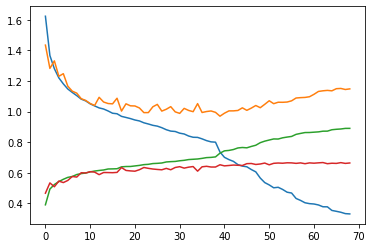

In [10]:
plt.plot(hist), best_acc

([<matplotlib.lines.Line2D at 0x7f14bcf4dbe0>,
 0.6667595430482028)

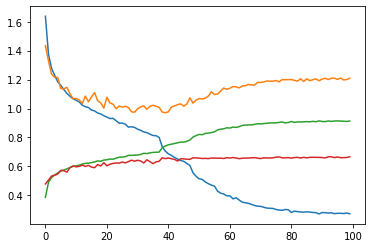

In [9]:
plt.plot(hist), best_acc

In [11]:
test_model = torch.load('featureactv4_whatever_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.080 | Avg. val_acc: 0.673


- Avg. val_loss: 1.155 | Avg. val_acc: 0.668

## Omit HW channels in cor

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1, dropout=0.):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        
        self.dropout = nn.Dropout(dropout)
        
        self.layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
#         self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        self.norm_conv = nn.Sequential(nn.Linear(self.dim, self.dim),
                                       nn.Dropout(dropout))
        
        self.src_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(self.dim, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        x_norm = self.layernorm(x)
        
        src_features = self.src_conv(x_norm)
        target_features = self.target_conv(x_norm)
        main_features = self.down_depth(x_norm)
        
        # cor has shape D x D
        cor = src_features.view(-1, self.dim, self.img_size * self.img_size) \
                @ target_features.view(-1, self.dim, self.img_size*self.img_size).permute(0, 2, 1)
        cor = cor / (math.sqrt(self.img_size * self.img_size))
#         cor = self.att_act(cor)
        cor = self.dropout(cor) # additional dropout to prevent overfitting

    
        cor_feature = torch.cat([(main_features.view(-1, self.dim, self.img_size*self.img_size).permute(0,2,1) \
                                  @ self.norm_conv(cor[:,:,k]).unsqueeze(-1)).view(-1, 1, self.img_size, self.img_size) \
                                  for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4, dropout=0.4)
        self.fact1 = FeatureAct(64, 12, 4, dropout=0.4)
        self.fact2 = FeatureAct(128, 6, 4, dropout=0.4)
        self.fact3 = FeatureAct(256, 3, 4, dropout=0.4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv4_omitHW_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.8403308391571045 Batch_id=224 Accuracy=0.21621621621621623: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 1.921 | Avg.acc: 0.220



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.827 | Avg. val_acc: 0.286
* Update optimal model
Epoch:  2


Loss=1.7544293403625488 Batch_id=224 Accuracy=0.2972972972972973: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]

- Avg.loss: 1.803 | Avg.acc: 0.279



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.746 | Avg. val_acc: 0.316
* Update optimal model
Epoch:  3


Loss=1.5644773244857788 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:34<00:00,  6.54it/s]

- Avg.loss: 1.714 | Avg.acc: 0.321



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.639 | Avg. val_acc: 0.353
* Update optimal model
Epoch:  4


Loss=1.5214556455612183 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:34<00:00,  6.57it/s]

- Avg.loss: 1.627 | Avg.acc: 0.361



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.529 | Avg. val_acc: 0.403
* Update optimal model
Epoch:  5


Loss=1.4477062225341797 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:34<00:00,  6.57it/s]

- Avg.loss: 1.509 | Avg.acc: 0.418



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.524 | Avg. val_acc: 0.410
* Update optimal model
Epoch:  6


Loss=1.436536431312561 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:34<00:00,  6.51it/s]

- Avg.loss: 1.401 | Avg.acc: 0.459



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.353 | Avg. val_acc: 0.491
* Update optimal model
Epoch:  7


Loss=1.255653977394104 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:34<00:00,  6.51it/s]

- Avg.loss: 1.341 | Avg.acc: 0.487



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.318 | Avg. val_acc: 0.496
* Update optimal model
Epoch:  8


Loss=1.2788864374160767 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:34<00:00,  6.54it/s]

- Avg.loss: 1.299 | Avg.acc: 0.500



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.265 | Avg. val_acc: 0.525
* Update optimal model
Epoch:  9


Loss=1.4683482646942139 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 1.265 | Avg.acc: 0.519



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.273 | Avg. val_acc: 0.509
Epoch:  10


Loss=1.3792868852615356 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:34<00:00,  6.52it/s]

- Avg.loss: 1.242 | Avg.acc: 0.528



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.199 | Avg. val_acc: 0.546
* Update optimal model
Epoch:  11


Loss=0.8858957886695862 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.52it/s]

- Avg.loss: 1.211 | Avg.acc: 0.540



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.172 | Avg. val_acc: 0.558
* Update optimal model
Epoch:  12


Loss=1.293101191520691 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.50it/s]

- Avg.loss: 1.193 | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.226 | Avg. val_acc: 0.538
Epoch:  13


Loss=0.896619439125061 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.177 | Avg.acc: 0.555



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.193 | Avg. val_acc: 0.553
Epoch:  14


Loss=1.516318917274475 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:34<00:00,  6.52it/s]

- Avg.loss: 1.153 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.161 | Avg. val_acc: 0.563
* Update optimal model
Epoch:  15


Loss=0.9674140214920044 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]

- Avg.loss: 1.130 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.121 | Avg. val_acc: 0.583
* Update optimal model
Epoch:  16


Loss=1.257460355758667 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:34<00:00,  6.57it/s]

- Avg.loss: 1.122 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.581
Epoch:  17


Loss=1.004520297050476 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 1.106 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.158 | Avg. val_acc: 0.556
Epoch:  18


Loss=1.2585604190826416 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:34<00:00,  6.52it/s]

- Avg.loss: 1.099 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.580
Epoch:  19


Loss=1.215143084526062 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 1.079 | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.061 | Avg. val_acc: 0.595
* Update optimal model
Epoch:  20


Loss=0.9343832731246948 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.52it/s]

- Avg.loss: 1.075 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.099 | Avg. val_acc: 0.588
Epoch:  21


Loss=1.1055878400802612 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]

- Avg.loss: 1.061 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.592
Epoch:  22


Loss=1.221814513206482 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:34<00:00,  6.51it/s]

- Avg.loss: 1.052 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.596
* Update optimal model
Epoch:  23


Loss=1.2785828113555908 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.54it/s]

- Avg.loss: 1.046 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.097 | Avg. val_acc: 0.582
Epoch:  24


Loss=1.1484675407409668 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.54it/s]

- Avg.loss: 1.031 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.602
* Update optimal model
Epoch:  25


Loss=0.9818494915962219 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:34<00:00,  6.54it/s]

- Avg.loss: 1.024 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.053 | Avg. val_acc: 0.610
* Update optimal model
Epoch:  26


Loss=1.0894628763198853 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.51it/s]

- Avg.loss: 1.016 | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.606
Epoch:  27


Loss=1.0472675561904907 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.57it/s]

- Avg.loss: 1.009 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.043 | Avg. val_acc: 0.613
* Update optimal model
Epoch:  28


Loss=1.0892505645751953 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 1.003 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.606
Epoch:  29


Loss=1.0858842134475708 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 0.990 | Avg.acc: 0.628



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.590
Epoch:  30


Loss=1.0102784633636475 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.57it/s]

- Avg.loss: 0.980 | Avg.acc: 0.633



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.046 | Avg. val_acc: 0.612
Epoch:  31


Loss=0.9853138327598572 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.52it/s]

- Avg.loss: 0.976 | Avg.acc: 0.636



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.075 | Avg. val_acc: 0.596
Epoch:  32


Loss=1.012277603149414 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.54it/s]

- Avg.loss: 0.971 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.590
Epoch:  33


Loss=1.0229158401489258 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.57it/s]

- Avg.loss: 0.961 | Avg.acc: 0.640



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.617
* Update optimal model
Epoch:  34


Loss=0.9414664506912231 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 0.959 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.616
Epoch:  35


Loss=1.0925532579421997 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 0.948 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.628
* Update optimal model
Epoch:  36


Loss=0.82917720079422 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.55it/s]

- Avg.loss: 0.936 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.049 | Avg. val_acc: 0.613
Epoch:  37


Loss=0.8714444041252136 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 0.940 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.012 | Avg. val_acc: 0.628
Epoch:  38


Loss=0.8089116811752319 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.51it/s]

- Avg.loss: 0.930 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.619
Epoch:  39


Loss=0.9800674915313721 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 0.923 | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.623
Epoch:  40


Loss=1.0469402074813843 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 0.922 | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.615
Epoch:  41


Loss=0.9142206311225891 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.51it/s]

- Avg.loss: 0.917 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.013 | Avg. val_acc: 0.628
Epoch:  42


Loss=1.1107494831085205 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.54it/s]

- Avg.loss: 0.903 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.613
Epoch:  43


Loss=0.7694320678710938 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.54it/s]

- Avg.loss: 0.899 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.627
Epoch    43: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  44


Loss=1.035721778869629 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 0.852 | Avg.acc: 0.685



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.984 | Avg. val_acc: 0.637
* Update optimal model
Epoch:  45


Loss=0.905674934387207 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]

- Avg.loss: 0.828 | Avg.acc: 0.691



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.972 | Avg. val_acc: 0.639
* Update optimal model
Epoch:  46


Loss=0.6807302236557007 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.50it/s]

- Avg.loss: 0.821 | Avg.acc: 0.697



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.962 | Avg. val_acc: 0.644
* Update optimal model
Epoch:  47


Loss=0.6823228597640991 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.57it/s]

- Avg.loss: 0.812 | Avg.acc: 0.699



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.646
* Update optimal model
Epoch:  48


Loss=0.7832747101783752 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 0.803 | Avg.acc: 0.704



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.650
* Update optimal model
Epoch:  49


Loss=0.6262088418006897 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.54it/s]

- Avg.loss: 0.799 | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.638
Epoch:  50


Loss=0.6842638254165649 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.57it/s]

- Avg.loss: 0.792 | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.642
Epoch:  51


Loss=0.7789623737335205 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 0.782 | Avg.acc: 0.712



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.646
Epoch:  52


Loss=0.5764123797416687 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]

- Avg.loss: 0.773 | Avg.acc: 0.715



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.983 | Avg. val_acc: 0.644
Epoch:  53


Loss=1.0949268341064453 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.49it/s]

- Avg.loss: 0.766 | Avg.acc: 0.718



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.641
Epoch:  54


Loss=0.7674655318260193 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.52it/s]

- Avg.loss: 0.760 | Avg.acc: 0.720



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.641
Epoch    54: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  55


Loss=0.732840359210968 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]

- Avg.loss: 0.722 | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.653
* Update optimal model
Epoch:  56


Loss=0.7444010376930237 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.51it/s]

- Avg.loss: 0.711 | Avg.acc: 0.740



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.978 | Avg. val_acc: 0.654
* Update optimal model
Epoch:  57


Loss=0.6904160976409912 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.54it/s]

- Avg.loss: 0.699 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.654
Epoch:  58


Loss=0.6163701415061951 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]

- Avg.loss: 0.690 | Avg.acc: 0.752



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.984 | Avg. val_acc: 0.651
Epoch:  59


Loss=0.9352850914001465 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 0.666 | Avg.acc: 0.763



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.648
Epoch:  62


Loss=0.9216805696487427 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.52it/s]

- Avg.loss: 0.663 | Avg.acc: 0.761



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.652
Epoch    62: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  63


Loss=0.8296499252319336 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.57it/s]

- Avg.loss: 0.628 | Avg.acc: 0.774



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.648
Epoch:  64


Loss=0.8850694894790649 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.57it/s]

- Avg.loss: 0.625 | Avg.acc: 0.776



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.650
Epoch:  65


Loss=0.5235339999198914 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 0.625 | Avg.acc: 0.775



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.649
Epoch:  66


Loss=0.6344442963600159 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.52it/s]

- Avg.loss: 0.616 | Avg.acc: 0.780



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.647
Epoch:  67


Loss=0.6656621098518372 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.49it/s]

- Avg.loss: 0.609 | Avg.acc: 0.781



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.651
Epoch:  68


Loss=0.7538111805915833 Batch_id=85 Accuracy=0.7578125:  38%|███▊      | 85/225 [00:14<00:20,  6.94it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.610988199710846 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.55it/s]

- Avg.loss: 0.580 | Avg.acc: 0.793



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.653
Epoch:  72


Loss=0.6016778945922852 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.51it/s]

- Avg.loss: 0.573 | Avg.acc: 0.795



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.653
Epoch:  73


Loss=0.4921901226043701 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]

- Avg.loss: 0.568 | Avg.acc: 0.800



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.654
Epoch:  74


Loss=0.32634592056274414 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 0.560 | Avg.acc: 0.803



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.653
Epoch:  75


Loss=0.37721410393714905 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 0.553 | Avg.acc: 0.805



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.042 | Avg. val_acc: 0.652
Epoch:  76


Loss=0.450563907623291 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:34<00:00,  6.54it/s]

- Avg.loss: 0.556 | Avg.acc: 0.805



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.646
Epoch:  77


Loss=0.5908842086791992 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 0.551 | Avg.acc: 0.806



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059 | Avg. val_acc: 0.648
Epoch:  78


Loss=0.6671608686447144 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]

- Avg.loss: 0.549 | Avg.acc: 0.805



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.646
Epoch    78: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  79


Loss=0.6135201454162598 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.57it/s]

- Avg.loss: 0.542 | Avg.acc: 0.807



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.064 | Avg. val_acc: 0.647
Epoch:  80


Loss=0.9374799132347107 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 0.543 | Avg.acc: 0.809



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.064 | Avg. val_acc: 0.656
Epoch:  81


Loss=0.3878743648529053 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 0.539 | Avg.acc: 0.810



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.648
Epoch:  82


Loss=0.42865458130836487 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 0.536 | Avg.acc: 0.810



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059 | Avg. val_acc: 0.653
Epoch:  83


Loss=0.4662719964981079 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]

- Avg.loss: 0.531 | Avg.acc: 0.813



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.649
Epoch:  84


Loss=0.4262629449367523 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]

- Avg.loss: 0.533 | Avg.acc: 0.814



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.651
Epoch:  85


Loss=0.5445857644081116 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.52it/s]

- Avg.loss: 0.532 | Avg.acc: 0.812



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.063 | Avg. val_acc: 0.647
Epoch:  86


Loss=0.33859196305274963 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:34<00:00,  6.55it/s]

- Avg.loss: 0.529 | Avg.acc: 0.814



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.062 | Avg. val_acc: 0.650
Epoch    86: reducing learning rate of group 0 to 1.5625e-05.
Epoch:  87


Loss=0.7877623438835144 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 0.522 | Avg.acc: 0.816



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.650
Epoch:  88


Loss=0.4401363730430603 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 0.528 | Avg.acc: 0.815



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.075 | Avg. val_acc: 0.650
Epoch:  89


Loss=0.4618310034275055 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:34<00:00,  6.62it/s]

- Avg.loss: 0.518 | Avg.acc: 0.818



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.651
Epoch:  90


Loss=0.7409655451774597 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 0.526 | Avg.acc: 0.816



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.653
Epoch:  91


Loss=0.5684741139411926 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:34<00:00,  6.55it/s]

- Avg.loss: 0.518 | Avg.acc: 0.818



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.071 | Avg. val_acc: 0.654
Epoch:  92


Loss=0.6571857929229736 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.57it/s]

- Avg.loss: 0.518 | Avg.acc: 0.818



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080 | Avg. val_acc: 0.654
Epoch:  93


Loss=0.4625403881072998 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:34<00:00,  6.50it/s]

- Avg.loss: 0.517 | Avg.acc: 0.818



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.652
Epoch:  94


Loss=0.537470817565918 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.54it/s]

- Avg.loss: 0.519 | Avg.acc: 0.818



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079 | Avg. val_acc: 0.652
Epoch    94: reducing learning rate of group 0 to 7.8125e-06.
Epoch:  95


Loss=0.5530931353569031 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 0.517 | Avg.acc: 0.818



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.077 | Avg. val_acc: 0.651
Epoch:  96


Loss=0.5865293741226196 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.57it/s]

- Avg.loss: 0.514 | Avg.acc: 0.821



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.654
Epoch:  97


Loss=0.5775995850563049 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]

- Avg.loss: 0.512 | Avg.acc: 0.822



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.650
Epoch:  98


Loss=0.44605129957199097 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 0.519 | Avg.acc: 0.818



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.077 | Avg. val_acc: 0.650
Epoch:  99


Loss=0.5771816372871399 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.52it/s]

- Avg.loss: 0.506 | Avg.acc: 0.823



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.082 | Avg. val_acc: 0.648
Epoch:  100


Loss=0.507787823677063 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.55it/s]

- Avg.loss: 0.514 | Avg.acc: 0.820


- Avg. val_loss: 1.070 | Avg. val_acc: 0.652
Finished Training


([<matplotlib.lines.Line2D at 0x7f621978af98>,
 0.6581220395653385)

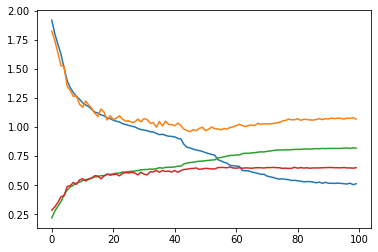

In [9]:
plt.plot(hist), best_acc

In [10]:
test_model = torch.load('featureactv4_omitHW_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 0.985 | Avg. val_acc: 0.651


## Omit HW channels in cor w.o ReLU in down and up depth, + non-linear proj

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1, dropout=0.):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        
        self.dropout = nn.Dropout(dropout)
        
        self.layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        self.mid_layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        self.out_layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        
#         self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        self.norm_conv = nn.Sequential(nn.Linear(self.dim, self.dim),
                                       nn.Dropout(dropout))
        
        self.src_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(self.dim, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
        self.proj_conv = nn.Sequential(nn.Conv2d(self.src_depth, self.src_depth, kernel_size=1, padding=False),
                                       nn.ReLU())
        
    def forward(self, x):
        
        x_norm = self.layernorm(x)
        
        src_features = self.src_conv(x_norm)
        target_features = self.target_conv(x_norm)
        main_features = self.down_depth(x_norm)
        
        # cor has shape D x D
        cor = src_features.view(-1, self.dim, self.img_size * self.img_size) \
                @ target_features.view(-1, self.dim, self.img_size*self.img_size).permute(0, 2, 1)
        cor = cor / (math.sqrt(self.img_size * self.img_size))
#         cor = self.att_act(cor)
        cor = self.dropout(cor) # additional dropout to prevent overfitting

    
        cor_feature = torch.cat([(main_features.view(-1, self.dim, self.img_size*self.img_size).permute(0,2,1) \
                                  @ self.norm_conv(cor[:,:,k]).unsqueeze(-1)).view(-1, 1, self.img_size, self.img_size) \
                                  / math.sqrt(self.dim) for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
    
        # projection
        x_mid = x + cor_feature
        x_mid = self.mid_layernorm(x_mid)
        
        x_out = self.proj_conv(x_mid)
        x_out = x_out + x_mid
        
        x_out = self.out_layernorm(x_out)
        return x_out

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4, dropout=0.4)
        self.fact1 = FeatureAct(64, 12, 4, dropout=0.4)
        self.fact2 = FeatureAct(128, 6, 4, dropout=0.4)
        self.fact3 = FeatureAct(256, 3, 4, dropout=0.4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv4_omitHW_projconv_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.8969229459762573 Batch_id=224 Accuracy=0.24324324324324326: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]

- Avg.loss: 1.934 | Avg.acc: 0.206



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.861 | Avg. val_acc: 0.271
* Update optimal model
Epoch:  2


Loss=1.9135944843292236 Batch_id=224 Accuracy=0.1891891891891892: 100%|██████████| 225/225 [00:36<00:00,  6.17it/s]

- Avg.loss: 1.833 | Avg.acc: 0.265



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.778 | Avg. val_acc: 0.303
* Update optimal model
Epoch:  3


Loss=1.6405069828033447 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:36<00:00,  6.19it/s]

- Avg.loss: 1.765 | Avg.acc: 0.293



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.733 | Avg. val_acc: 0.312
* Update optimal model
Epoch:  4


Loss=1.700711965560913 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [00:36<00:00,  6.18it/s]

- Avg.loss: 1.702 | Avg.acc: 0.322



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.656 | Avg. val_acc: 0.349
* Update optimal model
Epoch:  5


Loss=1.6723499298095703 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 1.652 | Avg.acc: 0.344



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.585 | Avg. val_acc: 0.390
* Update optimal model
Epoch:  6


Loss=1.4435077905654907 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:35<00:00,  6.26it/s]

- Avg.loss: 1.604 | Avg.acc: 0.363



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.533 | Avg. val_acc: 0.408
* Update optimal model
Epoch:  7


Loss=1.5560145378112793 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:35<00:00,  6.27it/s]

- Avg.loss: 1.546 | Avg.acc: 0.397



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.515 | Avg. val_acc: 0.409
* Update optimal model
Epoch:  8


Loss=1.3909285068511963 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.32it/s]

- Avg.loss: 1.488 | Avg.acc: 0.423



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.416 | Avg. val_acc: 0.458
* Update optimal model
Epoch:  9


Loss=1.1768547296524048 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:35<00:00,  6.25it/s]

- Avg.loss: 1.411 | Avg.acc: 0.455



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.447 | Avg. val_acc: 0.446
Epoch:  10


Loss=1.382438063621521 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:36<00:00,  6.16it/s]

- Avg.loss: 1.354 | Avg.acc: 0.482



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.313 | Avg. val_acc: 0.487
* Update optimal model
Epoch:  11


Loss=1.2450072765350342 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:36<00:00,  6.19it/s]

- Avg.loss: 1.312 | Avg.acc: 0.497



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.268 | Avg. val_acc: 0.514
* Update optimal model
Epoch:  12


Loss=1.3467981815338135 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 1.287 | Avg.acc: 0.507



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.264 | Avg. val_acc: 0.521
* Update optimal model
Epoch:  13


Loss=1.5773546695709229 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:35<00:00,  6.25it/s]

- Avg.loss: 1.259 | Avg.acc: 0.518



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.250 | Avg. val_acc: 0.520
Epoch:  14


Loss=1.5599217414855957 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:36<00:00,  6.24it/s]

- Avg.loss: 1.241 | Avg.acc: 0.529



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.200 | Avg. val_acc: 0.539
* Update optimal model
Epoch:  15


Loss=1.1638551950454712 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 1.230 | Avg.acc: 0.532



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.221 | Avg. val_acc: 0.528
Epoch:  16


Loss=1.1557300090789795 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.27it/s]

- Avg.loss: 1.208 | Avg.acc: 0.541



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.167 | Avg. val_acc: 0.561
* Update optimal model
Epoch:  17


Loss=0.9997270703315735 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:36<00:00,  6.20it/s]

- Avg.loss: 1.191 | Avg.acc: 0.547



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.196 | Avg. val_acc: 0.551
Epoch:  18


Loss=1.2088756561279297 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.26it/s]

- Avg.loss: 1.185 | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.287 | Avg. val_acc: 0.502
Epoch:  19


Loss=1.1328500509262085 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:36<00:00,  6.19it/s]

- Avg.loss: 1.169 | Avg.acc: 0.557



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.574
* Update optimal model
Epoch:  20


Loss=1.1840258836746216 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:36<00:00,  6.25it/s]

- Avg.loss: 1.156 | Avg.acc: 0.562



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.129 | Avg. val_acc: 0.571
Epoch:  21


Loss=1.0925911664962769 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:36<00:00,  6.25it/s]

- Avg.loss: 1.144 | Avg.acc: 0.568



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.145 | Avg. val_acc: 0.566
Epoch:  22


Loss=1.0729669332504272 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 1.134 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.224 | Avg. val_acc: 0.528
Epoch:  23


Loss=1.2879794836044312 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.27it/s]

- Avg.loss: 1.129 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.146 | Avg. val_acc: 0.562
Epoch:  24


Loss=1.2084273099899292 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 1.116 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.565
Epoch:  25


Loss=1.245105504989624 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.27it/s]

- Avg.loss: 1.111 | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.100 | Avg. val_acc: 0.582
* Update optimal model
Epoch:  26


Loss=1.2404568195343018 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 1.103 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.167 | Avg. val_acc: 0.564
Epoch:  27


Loss=1.296144723892212 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:36<00:00,  6.25it/s]

- Avg.loss: 1.093 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.152 | Avg. val_acc: 0.551
Epoch:  28


Loss=1.0324772596359253 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:36<00:00,  6.24it/s]

- Avg.loss: 1.086 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103 | Avg. val_acc: 0.589
* Update optimal model
Epoch:  29


Loss=0.86864173412323 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 1.073 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090 | Avg. val_acc: 0.589
Epoch:  30


Loss=1.1108475923538208 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:36<00:00,  6.18it/s]

- Avg.loss: 1.071 | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.095 | Avg. val_acc: 0.580
Epoch:  31


Loss=1.1107639074325562 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 1.064 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.100 | Avg. val_acc: 0.583
Epoch:  32


Loss=1.3690714836120605 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:36<00:00,  6.25it/s]

- Avg.loss: 1.054 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.592
* Update optimal model
Epoch:  33


Loss=1.06410813331604 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 1.052 | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098 | Avg. val_acc: 0.583
Epoch:  34


Loss=0.9916620254516602 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:36<00:00,  6.20it/s]

- Avg.loss: 1.046 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.585
Epoch:  35


Loss=1.0237690210342407 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 1.040 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098 | Avg. val_acc: 0.581
Epoch:  36


Loss=1.0658414363861084 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:36<00:00,  6.19it/s]

- Avg.loss: 1.026 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.580
Epoch:  37


Loss=1.1911216974258423 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]

- Avg.loss: 1.031 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.089 | Avg. val_acc: 0.594
* Update optimal model
Epoch:  38


Loss=1.4084821939468384 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 1.017 | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079 | Avg. val_acc: 0.597
* Update optimal model
Epoch:  39


Loss=1.0245252847671509 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 1.014 | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.100 | Avg. val_acc: 0.586
Epoch:  40


Loss=1.0381574630737305 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:36<00:00,  6.18it/s]

- Avg.loss: 1.007 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.130 | Avg. val_acc: 0.574
Epoch:  41


Loss=1.1295665502548218 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:36<00:00,  6.20it/s]

- Avg.loss: 1.005 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056 | Avg. val_acc: 0.605
* Update optimal model
Epoch:  42


Loss=0.959488034248352 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 1.000 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.586
Epoch:  43


Loss=0.8030236959457397 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:35<00:00,  6.27it/s]

- Avg.loss: 0.989 | Avg.acc: 0.626



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098 | Avg. val_acc: 0.588
Epoch:  44


Loss=1.0133159160614014 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]

- Avg.loss: 0.992 | Avg.acc: 0.626



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.063 | Avg. val_acc: 0.605
* Update optimal model
Epoch:  45


Loss=1.2164157629013062 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:36<00:00,  6.15it/s]

- Avg.loss: 0.985 | Avg.acc: 0.630



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.055 | Avg. val_acc: 0.600
Epoch:  46


Loss=1.1627193689346313 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.978 | Avg.acc: 0.634



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.609
* Update optimal model
Epoch:  47


Loss=1.3462413549423218 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.977 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072 | Avg. val_acc: 0.601
Epoch:  48


Loss=1.047860860824585 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]

- Avg.loss: 0.969 | Avg.acc: 0.635



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.043 | Avg. val_acc: 0.607
Epoch:  49


Loss=0.7261015772819519 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:36<00:00,  6.17it/s]

- Avg.loss: 0.966 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056 | Avg. val_acc: 0.603
Epoch:  50


Loss=0.8930324912071228 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.963 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.617
* Update optimal model
Epoch:  51


Loss=1.0974751710891724 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.957 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.607
Epoch:  52


Loss=0.9660019874572754 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:36<00:00,  6.24it/s]

- Avg.loss: 0.946 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.614
Epoch:  53


Loss=0.8541438579559326 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:36<00:00,  6.19it/s]

- Avg.loss: 0.949 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079 | Avg. val_acc: 0.605
Epoch:  54


Loss=1.1444988250732422 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:36<00:00,  6.19it/s]

- Avg.loss: 0.949 | Avg.acc: 0.646



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.620
* Update optimal model
Epoch:  55


Loss=0.7500371336936951 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.941 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.595
Epoch:  56


Loss=0.826589047908783 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.934 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047 | Avg. val_acc: 0.616
Epoch:  57


Loss=0.8117799162864685 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:36<00:00,  6.21it/s]

- Avg.loss: 0.933 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.622
* Update optimal model
Epoch:  58


Loss=0.859106719493866 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:36<00:00,  6.21it/s]

- Avg.loss: 0.925 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033 | Avg. val_acc: 0.616
Epoch:  59


Loss=0.8144048452377319 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:36<00:00,  6.19it/s]

- Avg.loss: 0.922 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.611
Epoch:  60


Loss=0.9795026183128357 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 0.923 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.042 | Avg. val_acc: 0.609
Epoch:  61


Loss=0.830622673034668 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.26it/s]

- Avg.loss: 0.921 | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.621
Epoch:  62


Loss=0.7690345048904419 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.26it/s]

- Avg.loss: 0.916 | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.603
Epoch:  63


Loss=0.8562032580375671 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.911 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.049 | Avg. val_acc: 0.614
Epoch:  64


Loss=1.188926100730896 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.909 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.616
Epoch:  65


Loss=1.0580626726150513 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.902 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.071 | Avg. val_acc: 0.615
Epoch    65: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  66


Loss=0.9055691361427307 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:36<00:00,  6.25it/s]

- Avg.loss: 0.858 | Avg.acc: 0.679



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.013 | Avg. val_acc: 0.623
* Update optimal model
Epoch:  67


Loss=0.7880480885505676 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:36<00:00,  6.17it/s]

- Avg.loss: 0.839 | Avg.acc: 0.686



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033 | Avg. val_acc: 0.623
* Update optimal model
Epoch:  68


Loss=1.0007107257843018 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:37<00:00,  6.08it/s]

- Avg.loss: 0.833 | Avg.acc: 0.691



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.626
* Update optimal model
Epoch:  69


Loss=0.7394365668296814 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:35<00:00,  6.25it/s]

- Avg.loss: 0.820 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.633
* Update optimal model
Epoch:  70


Loss=0.6587343811988831 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:35<00:00,  6.30it/s]

- Avg.loss: 0.817 | Avg.acc: 0.700



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038 | Avg. val_acc: 0.622
Epoch:  71


Loss=0.7438989877700806 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:35<00:00,  6.25it/s]

- Avg.loss: 0.811 | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.626
Epoch:  72


Loss=0.9539093971252441 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.802 | Avg.acc: 0.703



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038 | Avg. val_acc: 0.620
Epoch:  73


Loss=0.7873522639274597 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:36<00:00,  6.18it/s]

- Avg.loss: 0.797 | Avg.acc: 0.707



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.624
Epoch:  74


Loss=0.8469368815422058 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:36<00:00,  6.24it/s]

- Avg.loss: 0.797 | Avg.acc: 0.705



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.616
Epoch    74: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  75


Loss=0.6370447278022766 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.764 | Avg.acc: 0.720



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.637
* Update optimal model
Epoch:  76


Loss=0.6417955160140991 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:36<00:00,  6.18it/s]

- Avg.loss: 0.733 | Avg.acc: 0.730



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.630
Epoch:  80


Loss=1.2560181617736816 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 0.727 | Avg.acc: 0.733



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.046 | Avg. val_acc: 0.633
Epoch:  81


Loss=0.6108722686767578 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 0.718 | Avg.acc: 0.737



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.626
Epoch:  82


Loss=0.7915972471237183 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 0.719 | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059 | Avg. val_acc: 0.627
Epoch    82: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  83


Loss=0.760158121585846 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:36<00:00,  6.21it/s]

- Avg.loss: 0.697 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.633
Epoch:  84


Loss=0.5515838265419006 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:36<00:00,  6.24it/s]

- Avg.loss: 0.691 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059 | Avg. val_acc: 0.632
Epoch:  85


Loss=0.7528693675994873 Batch_id=140 Accuracy=0.7421875:  63%|██████▎   | 141/225 [00:23<00:12,  6.47it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.853444516658783 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 0.655 | Avg.acc: 0.764



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.077 | Avg. val_acc: 0.634
Epoch:  93


Loss=0.8272743821144104 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:36<00:00,  6.21it/s]

- Avg.loss: 0.652 | Avg.acc: 0.766



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.065 | Avg. val_acc: 0.635
Epoch:  94


Loss=0.7568502426147461 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:36<00:00,  6.24it/s]

- Avg.loss: 0.651 | Avg.acc: 0.764



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.071 | Avg. val_acc: 0.634
Epoch:  95


Loss=0.7269358038902283 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:36<00:00,  6.25it/s]

- Avg.loss: 0.644 | Avg.acc: 0.767



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.632
Epoch:  96


Loss=0.6717017889022827 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:36<00:00,  6.19it/s]

- Avg.loss: 0.642 | Avg.acc: 0.770



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079 | Avg. val_acc: 0.634
Epoch:  97


Loss=0.840083122253418 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.640 | Avg.acc: 0.766



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080 | Avg. val_acc: 0.635
Epoch:  98


Loss=0.5022995471954346 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:35<00:00,  6.26it/s]

- Avg.loss: 0.641 | Avg.acc: 0.769



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.087 | Avg. val_acc: 0.632
Epoch    98: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  99


Loss=0.6680387854576111 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 0.638 | Avg.acc: 0.773



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.634
Epoch:  100


Loss=0.4921320974826813 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.627 | Avg.acc: 0.774


- Avg. val_loss: 1.086 | Avg. val_acc: 0.635
Finished Training


([<matplotlib.lines.Line2D at 0x7f26806c5c50>,
 0.636667595430482)

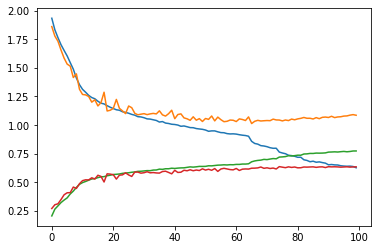

In [11]:
import pickle
pickle.dump(hist, open('featureactv4_omitHW_projconv_baseline_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [10]:
test_model = torch.load('featureactv4_omitHW_projconv_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.005 | Avg. val_acc: 0.636


## - normalized after CAM operation

In [8]:
model_path = './featureactv4_omitHW_projconv_norm_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.6180897951126099 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:37<00:00,  6.01it/s]

- Avg.loss: 1.701 | Avg.acc: 0.351



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.470 | Avg. val_acc: 0.459
* Update optimal model
Epoch:  2


Loss=1.2617623805999756 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:38<00:00,  5.86it/s]

- Avg.loss: 1.389 | Avg.acc: 0.484



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.293 | Avg. val_acc: 0.511
* Update optimal model
Epoch:  3


Loss=1.107232928276062 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:37<00:00,  5.95it/s]

- Avg.loss: 1.280 | Avg.acc: 0.525



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.254 | Avg. val_acc: 0.526
* Update optimal model
Epoch:  4


Loss=1.2211942672729492 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:38<00:00,  5.90it/s]

- Avg.loss: 1.223 | Avg.acc: 0.546



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.176 | Avg. val_acc: 0.567
* Update optimal model
Epoch:  5


Loss=1.056637167930603 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:38<00:00,  5.89it/s]

- Avg.loss: 1.182 | Avg.acc: 0.558



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.162 | Avg. val_acc: 0.568
* Update optimal model
Epoch:  6


Loss=1.035004734992981 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:37<00:00,  5.93it/s]

- Avg.loss: 1.110 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.115 | Avg. val_acc: 0.585
Epoch:  9


Loss=1.1371722221374512 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:38<00:00,  5.90it/s]

- Avg.loss: 1.098 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.082 | Avg. val_acc: 0.594
* Update optimal model
Epoch:  10


Loss=0.9678272604942322 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  5.94it/s]

- Avg.loss: 1.080 | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079 | Avg. val_acc: 0.603
* Update optimal model
Epoch:  11


Loss=1.012149453163147 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:37<00:00,  5.93it/s]

- Avg.loss: 1.071 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076 | Avg. val_acc: 0.591
Epoch:  12


Loss=0.9535080194473267 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  5.96it/s]

- Avg.loss: 1.049 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.597
Epoch:  13


Loss=1.018519639968872 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:37<00:00,  5.97it/s]

- Avg.loss: 1.040 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.586
Epoch:  14


Loss=1.1033655405044556 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  5.97it/s]

- Avg.loss: 1.032 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079 | Avg. val_acc: 0.593
Epoch:  15


Loss=1.1773861646652222 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:38<00:00,  5.91it/s]

- Avg.loss: 1.020 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.065 | Avg. val_acc: 0.595
Epoch:  16


Loss=0.8830810785293579 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:37<00:00,  5.94it/s]

- Avg.loss: 1.011 | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.605
* Update optimal model
Epoch:  17


Loss=1.020106554031372 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  5.93it/s]

- Avg.loss: 1.006 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.049 | Avg. val_acc: 0.598
Epoch:  18


Loss=1.2072899341583252 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:37<00:00,  5.97it/s]

- Avg.loss: 0.993 | Avg.acc: 0.628



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.617
* Update optimal model
Epoch:  19


Loss=0.7999201416969299 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:37<00:00,  6.01it/s]

- Avg.loss: 0.985 | Avg.acc: 0.630



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.611
Epoch:  20


Loss=0.877770721912384 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  5.95it/s]

- Avg.loss: 0.980 | Avg.acc: 0.630



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.042 | Avg. val_acc: 0.611
Epoch:  21


Loss=0.9202067255973816 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  5.96it/s]

- Avg.loss: 0.966 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.049 | Avg. val_acc: 0.605
Epoch:  22


Loss=1.075119972229004 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  5.96it/s]

- Avg.loss: 0.963 | Avg.acc: 0.640



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.625
* Update optimal model
Epoch:  23


Loss=1.1044081449508667 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:37<00:00,  5.94it/s]

- Avg.loss: 0.952 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047 | Avg. val_acc: 0.612
Epoch:  24


Loss=1.1777018308639526 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:37<00:00,  5.95it/s]

- Avg.loss: 0.946 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.617
Epoch:  25


Loss=0.772541344165802 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:37<00:00,  5.94it/s]

- Avg.loss: 0.931 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.042 | Avg. val_acc: 0.619
Epoch:  26


Loss=0.8721644282341003 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:37<00:00,  6.01it/s]

- Avg.loss: 0.925 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.624
Epoch:  27


Loss=0.8827676773071289 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:38<00:00,  5.90it/s]

- Avg.loss: 0.918 | Avg.acc: 0.657



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.623
Epoch:  28


Loss=0.9464166760444641 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:37<00:00,  5.99it/s]

- Avg.loss: 0.912 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.613
Epoch:  29


Loss=0.8186978101730347 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:37<00:00,  5.99it/s]

- Avg.loss: 0.903 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.620
Epoch:  30


Loss=0.9473325610160828 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:37<00:00,  5.98it/s]

- Avg.loss: 0.895 | Avg.acc: 0.668



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.615
Epoch:  31


Loss=0.7709723711013794 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:37<00:00,  5.95it/s]

- Avg.loss: 0.890 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.636
* Update optimal model
Epoch:  32


Loss=0.9447199106216431 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:38<00:00,  5.91it/s]

- Avg.loss: 0.883 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.631
Epoch:  33


Loss=0.9770585894584656 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:38<00:00,  5.91it/s]

- Avg.loss: 0.874 | Avg.acc: 0.674



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.627
Epoch:  34


Loss=1.0650523900985718 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:38<00:00,  5.90it/s]

- Avg.loss: 0.870 | Avg.acc: 0.677



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.615
Epoch:  35


Loss=0.7559877634048462 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:37<00:00,  5.93it/s]

- Avg.loss: 0.858 | Avg.acc: 0.677



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.012 | Avg. val_acc: 0.630
Epoch:  36


Loss=1.100454330444336 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:37<00:00,  5.98it/s]

- Avg.loss: 0.855 | Avg.acc: 0.681



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.627
Epoch:  37


Loss=0.9302625060081482 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:37<00:00,  5.94it/s]

- Avg.loss: 0.842 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.625
Epoch:  38


Loss=0.7414036393165588 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:37<00:00,  5.96it/s]

- Avg.loss: 0.840 | Avg.acc: 0.687



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.628
Epoch:  39


Loss=0.9553464651107788 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:37<00:00,  5.97it/s]

- Avg.loss: 0.837 | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.039 | Avg. val_acc: 0.620
Epoch:  40


Loss=0.6714964509010315 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:37<00:00,  5.96it/s]

- Avg.loss: 0.828 | Avg.acc: 0.694



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.631
Epoch:  41


Loss=0.80489581823349 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:38<00:00,  5.92it/s]

- Avg.loss: 0.823 | Avg.acc: 0.691



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.636
* Update optimal model
Epoch:  42


Loss=1.086655855178833 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:37<00:00,  5.93it/s]

- Avg.loss: 0.812 | Avg.acc: 0.697



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.626
Epoch:  43


Loss=0.8437337875366211 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:37<00:00,  6.00it/s]

- Avg.loss: 0.814 | Avg.acc: 0.697



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.624
Epoch:  44


Loss=0.6904698610305786 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:37<00:00,  5.93it/s]

- Avg.loss: 0.805 | Avg.acc: 0.701



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.631
Epoch:  45


Loss=0.7703584432601929 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:37<00:00,  5.92it/s]

- Avg.loss: 0.792 | Avg.acc: 0.704



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.630
Epoch:  46


Loss=0.8598623275756836 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  5.97it/s]

- Avg.loss: 0.789 | Avg.acc: 0.707



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.640
* Update optimal model
Epoch:  47


Loss=1.0839054584503174 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:38<00:00,  5.90it/s]

- Avg.loss: 0.780 | Avg.acc: 0.714



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.629
Epoch:  48


Loss=0.6558886766433716 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:37<00:00,  5.94it/s]

- Avg.loss: 0.775 | Avg.acc: 0.713



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.624
Epoch    48: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  49


Loss=0.6345154643058777 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:37<00:00,  5.93it/s]

- Avg.loss: 0.710 | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.650
* Update optimal model
Epoch:  50


Loss=0.6408711671829224 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:37<00:00,  5.94it/s]

- Avg.loss: 0.673 | Avg.acc: 0.757



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.644
Epoch:  51


Loss=0.7442898750305176 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:37<00:00,  5.94it/s]

- Avg.loss: 0.651 | Avg.acc: 0.763



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.639
Epoch:  52


Loss=0.837196409702301 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:37<00:00,  5.93it/s]

- Avg.loss: 0.642 | Avg.acc: 0.765



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.645
Epoch:  53


Loss=0.5960431098937988 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:37<00:00,  5.96it/s]

- Avg.loss: 0.631 | Avg.acc: 0.772



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.639
Epoch:  54


Loss=0.8441422581672668 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:37<00:00,  5.92it/s]

- Avg.loss: 0.615 | Avg.acc: 0.777



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.644
Epoch:  55


Loss=0.41360265016555786 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:37<00:00,  5.95it/s]

- Avg.loss: 0.611 | Avg.acc: 0.778



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.638
Epoch:  56


Loss=0.5061838626861572 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:38<00:00,  5.92it/s]

- Avg.loss: 0.596 | Avg.acc: 0.786



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.082 | Avg. val_acc: 0.645
Epoch:  57


Loss=0.5347921252250671 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:37<00:00,  5.96it/s]

- Avg.loss: 0.585 | Avg.acc: 0.787



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088 | Avg. val_acc: 0.637
Epoch    57: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  58


Loss=0.6868557929992676 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:38<00:00,  5.89it/s]

- Avg.loss: 0.537 | Avg.acc: 0.809



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080 | Avg. val_acc: 0.644
Epoch:  59


Loss=0.8925220370292664 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:37<00:00,  5.95it/s]

- Avg.loss: 0.509 | Avg.acc: 0.820



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.094 | Avg. val_acc: 0.649
Epoch:  60


Loss=0.6178781390190125 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:37<00:00,  5.92it/s]

- Avg.loss: 0.493 | Avg.acc: 0.826



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.111 | Avg. val_acc: 0.657
* Update optimal model
Epoch:  61


Loss=0.7860881090164185 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:37<00:00,  5.93it/s]

- Avg.loss: 0.481 | Avg.acc: 0.831



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.134 | Avg. val_acc: 0.643
Epoch:  62


Loss=0.495878130197525 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:37<00:00,  5.95it/s]

- Avg.loss: 0.478 | Avg.acc: 0.831



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116 | Avg. val_acc: 0.652
Epoch:  63


Loss=0.3965437710285187 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:38<00:00,  5.92it/s]

- Avg.loss: 0.465 | Avg.acc: 0.836



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.143 | Avg. val_acc: 0.641
Epoch:  64


Loss=0.49932944774627686 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:37<00:00,  5.95it/s]

- Avg.loss: 0.450 | Avg.acc: 0.844



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.150 | Avg. val_acc: 0.635
Epoch:  65


Loss=0.7553426623344421 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:37<00:00,  5.93it/s]

- Avg.loss: 0.444 | Avg.acc: 0.846



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.163 | Avg. val_acc: 0.643
Epoch    65: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  66


Loss=0.43409910798072815 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:37<00:00,  5.98it/s]

- Avg.loss: 0.419 | Avg.acc: 0.855



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.156 | Avg. val_acc: 0.648
Epoch:  67


Loss=0.4598538279533386 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:37<00:00,  5.95it/s]

- Avg.loss: 0.398 | Avg.acc: 0.865



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.157 | Avg. val_acc: 0.648
Epoch:  68


Loss=0.513742208480835 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:37<00:00,  5.95it/s]

- Avg.loss: 0.388 | Avg.acc: 0.867



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.169 | Avg. val_acc: 0.648
Epoch:  69


Loss=0.18700110912322998 Batch_id=224 Accuracy=0.972972972972973: 100%|██████████| 225/225 [00:38<00:00,  5.92it/s]

- Avg.loss: 0.383 | Avg.acc: 0.870



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.179 | Avg. val_acc: 0.646
Epoch:  70


Loss=0.3087965250015259 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:37<00:00,  5.97it/s]

- Avg.loss: 0.375 | Avg.acc: 0.874



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.185 | Avg. val_acc: 0.645
Epoch:  71


Loss=0.415621280670166 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:38<00:00,  5.89it/s]

- Avg.loss: 0.371 | Avg.acc: 0.873



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.203 | Avg. val_acc: 0.642
Epoch:  72


Loss=0.3775966167449951 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:37<00:00,  5.95it/s]

- Avg.loss: 0.357 | Avg.acc: 0.879



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.203 | Avg. val_acc: 0.645
Epoch:  73


Loss=0.46596378087997437 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:37<00:00,  5.96it/s]

- Avg.loss: 0.354 | Avg.acc: 0.879



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.213 | Avg. val_acc: 0.638
Epoch    73: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  74


Loss=0.404365211725235 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:37<00:00,  5.95it/s]

- Avg.loss: 0.338 | Avg.acc: 0.887



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.203 | Avg. val_acc: 0.640
Epoch:  75


Loss=0.29428631067276 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:37<00:00,  5.94it/s]

- Avg.loss: 0.337 | Avg.acc: 0.888



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.216 | Avg. val_acc: 0.644
Epoch:  76


Loss=0.5191567540168762 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:37<00:00,  5.97it/s]

- Avg.loss: 0.323 | Avg.acc: 0.893



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.222 | Avg. val_acc: 0.641
Epoch:  77


Loss=0.24816742539405823 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [00:37<00:00,  5.95it/s]

- Avg.loss: 0.328 | Avg.acc: 0.892



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.220 | Avg. val_acc: 0.642
Epoch:  78


Loss=0.34984004497528076 Batch_id=65 Accuracy=0.8828125:  29%|██▉       | 66/225 [00:12<00:30,  5.28it/s]


KeyboardInterrupt: 

([<matplotlib.lines.Line2D at 0x7f74588205c0>,
 0.657286152131513)

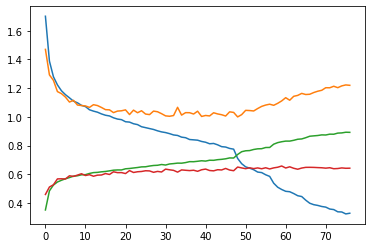

In [9]:
plt.plot(hist), best_acc

In [10]:
test_model = torch.load('featureactv4_omitHW_projconv_norm_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.062 | Avg. val_acc: 0.651


## Omit HW channels in cor w.o ReLU in down and up depth, + non-linear proj use 2 facts

In [7]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1, dropout=0.):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        
        self.layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        self.mid_layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        self.out_layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        
#         self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        self.norm_conv = nn.Sequential(nn.Dropout(dropout), 
                                       nn.Linear(self.dim, self.dim))
        
        self.src_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(self.dim, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
        self.proj_conv = nn.Sequential(nn.Conv2d(self.src_depth, self.src_depth, kernel_size=1, padding=False),
                                       nn.ReLU())
        
        self.alpha = Parameter(torch.zeros(1), requires_grad=True)
        self.beta = Parameter(torch.zeros(1), requires_grad=True)
        
    def forward(self, x):
        
        x_norm = self.layernorm(x)
        
        src_features = self.src_conv(x_norm)
        target_features = self.target_conv(x_norm)
        main_features = self.down_depth(x_norm)
        
        # cor has shape D x D
        cor = src_features.view(-1, self.dim, self.img_size * self.img_size) \
                @ target_features.view(-1, self.dim, self.img_size*self.img_size).permute(0, 2, 1)
        cor = cor / (math.sqrt(self.img_size * self.img_size))
#         cor = self.att_act(cor)
    
        cor_feature = torch.cat([(main_features.view(-1, self.dim, self.img_size*self.img_size).permute(0,2,1) \
                                  @ self.norm_conv(cor[:,:,k]).unsqueeze(-1)).view(-1, 1, self.img_size, self.img_size) \
                                    for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
    
        # projection
        x_mid = x + (self.alpha * cor_feature)
        x_mid = self.mid_layernorm(x_mid)
        
        x_out = self.proj_conv(x_mid)
        x_out = x_out + (self.beta * x_mid)
        
        x_out = self.out_layernorm(x_out)
        return x_out

In [8]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

#         self.fact0 = FeatureAct(32, 24, 4, dropout=0.4)
#         self.fact1 = FeatureAct(64, 12, 4, dropout=0.4)
        self.fact2 = FeatureAct(128, 6, 4, dropout=0.4)
        self.fact3 = FeatureAct(256, 3, 4, dropout=0.4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
#         x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
#         x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [9]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [10]:
model_path = './featureactv4_omitHW_projconv_2facts_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.4986718893051147 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 1.657 | Avg.acc: 0.378



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.432 | Avg. val_acc: 0.471
* Update optimal model
Epoch:  2


Loss=1.357308030128479 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 1.376 | Avg.acc: 0.490



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.310 | Avg. val_acc: 0.510
* Update optimal model
Epoch:  3


Loss=1.250710129737854 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 1.287 | Avg.acc: 0.523



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.323 | Avg. val_acc: 0.517
* Update optimal model
Epoch:  4


Loss=1.202788233757019 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]

- Avg.loss: 1.231 | Avg.acc: 0.539



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.229 | Avg. val_acc: 0.541
* Update optimal model
Epoch:  5


Loss=1.3598748445510864 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 1.196 | Avg.acc: 0.553



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.165 | Avg. val_acc: 0.554
* Update optimal model
Epoch:  6


Loss=0.9873350858688354 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 1.159 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.164 | Avg. val_acc: 0.569
* Update optimal model
Epoch:  7


Loss=1.1418747901916504 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 1.135 | Avg.acc: 0.577



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.161 | Avg. val_acc: 0.566
Epoch:  8


Loss=1.073241114616394 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]

- Avg.loss: 1.117 | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.146 | Avg. val_acc: 0.576
* Update optimal model
Epoch:  9


Loss=0.8761996626853943 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 1.102 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.134 | Avg. val_acc: 0.570
Epoch:  10


Loss=1.424385905265808 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 1.085 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.588
* Update optimal model
Epoch:  11


Loss=1.1014317274093628 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:29<00:00,  7.60it/s]

- Avg.loss: 1.074 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088 | Avg. val_acc: 0.594
* Update optimal model
Epoch:  12


Loss=0.8652832508087158 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 1.058 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.065 | Avg. val_acc: 0.606
* Update optimal model
Epoch:  13


Loss=0.9845923185348511 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 1.046 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.046 | Avg. val_acc: 0.607
* Update optimal model
Epoch:  14


Loss=1.417502522468567 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 1.028 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.093 | Avg. val_acc: 0.582
Epoch:  15


Loss=1.0777069330215454 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 1.024 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.048 | Avg. val_acc: 0.612
* Update optimal model
Epoch:  16


Loss=1.0853220224380493 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 1.009 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.048 | Avg. val_acc: 0.604
Epoch:  17


Loss=1.229800820350647 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 1.003 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.051 | Avg. val_acc: 0.604
Epoch:  18


Loss=0.9072573781013489 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.997 | Avg.acc: 0.626



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.609
Epoch:  19


Loss=1.0746222734451294 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.983 | Avg.acc: 0.631



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.611
Epoch:  20


Loss=1.5816936492919922 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.972 | Avg.acc: 0.635



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.603
Epoch:  21


Loss=1.170623779296875 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.972 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033 | Avg. val_acc: 0.612
Epoch:  22


Loss=0.9106202125549316 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.953 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.622
* Update optimal model
Epoch:  23


Loss=0.9711635708808899 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 0.955 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.624
* Update optimal model
Epoch:  24


Loss=0.9088921546936035 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.945 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.618
Epoch:  25


Loss=0.8504549860954285 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.940 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.620
Epoch:  26


Loss=1.141797661781311 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.934 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.625
* Update optimal model
Epoch:  27


Loss=0.9226366877555847 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]

- Avg.loss: 0.920 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.607
Epoch:  28


Loss=1.2787240743637085 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.917 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.624
Epoch:  29


Loss=0.7051040530204773 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.907 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.618
Epoch:  30


Loss=0.8160685300827026 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.893 | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.630
* Update optimal model
Epoch:  31


Loss=1.000307559967041 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.896 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.626
Epoch:  32


Loss=0.93732750415802 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.882 | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.623
Epoch:  33


Loss=0.9763948321342468 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.884 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.624
Epoch:  34


Loss=0.734565794467926 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.877 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.614
Epoch:  35


Loss=0.9524900317192078 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.866 | Avg.acc: 0.677



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.005 | Avg. val_acc: 0.623
Epoch:  36


Loss=0.6522069573402405 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 0.858 | Avg.acc: 0.682



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.631
* Update optimal model
Epoch:  37


Loss=0.7040457129478455 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.859 | Avg.acc: 0.677



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.623
Epoch:  38


Loss=0.9657939076423645 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.846 | Avg.acc: 0.681



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.625
Epoch    38: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  39


Loss=0.7227686643600464 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.784 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.980 | Avg. val_acc: 0.644
* Update optimal model
Epoch:  40


Loss=0.6826123595237732 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.760 | Avg.acc: 0.720



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.642
Epoch:  41


Loss=0.626566469669342 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.707 | Avg.acc: 0.739



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.643
Epoch:  45


Loss=0.6940663456916809 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.697 | Avg.acc: 0.742



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.649
Epoch:  46


Loss=0.6293429136276245 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.685 | Avg.acc: 0.750



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.654
* Update optimal model
Epoch:  47


Loss=0.6116043329238892 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.678 | Avg.acc: 0.752



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.653
Epoch    47: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  48


Loss=0.6665185689926147 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.630 | Avg.acc: 0.771



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.661
* Update optimal model
Epoch:  49


Loss=0.6920621395111084 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.602 | Avg.acc: 0.784



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.013 | Avg. val_acc: 0.661
* Update optimal model
Epoch:  50


Loss=0.532655656337738 Batch_id=181 Accuracy=0.828125:  81%|████████  | 182/225 [00:24<00:05,  7.92it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.0405681133270264 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.553 | Avg.acc: 0.800



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.042 | Avg. val_acc: 0.651
Epoch:  54


Loss=0.8324563503265381 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.549 | Avg.acc: 0.803



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.651
Epoch:  55


Loss=0.7816480398178101 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.529 | Avg.acc: 0.811



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.065 | Avg. val_acc: 0.656
Epoch    55: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  56


Loss=0.44971340894699097 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.500 | Avg.acc: 0.824



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.060 | Avg. val_acc: 0.658
Epoch:  57


Loss=0.8056466579437256 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]

- Avg.loss: 0.485 | Avg.acc: 0.828



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.082 | Avg. val_acc: 0.657
Epoch:  58


Loss=0.3966541290283203 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.472 | Avg.acc: 0.835



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.081 | Avg. val_acc: 0.662
* Update optimal model
Epoch:  59


Loss=0.42776909470558167 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.472 | Avg.acc: 0.836



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083 | Avg. val_acc: 0.656
Epoch:  60


Loss=0.6965299844741821 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.459 | Avg.acc: 0.839



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.655
Epoch:  61


Loss=0.512066662311554 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.452 | Avg.acc: 0.844



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.094 | Avg. val_acc: 0.648
Epoch:  62


Loss=0.27860045433044434 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.442 | Avg.acc: 0.847



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.101 | Avg. val_acc: 0.660
Epoch:  63


Loss=0.4034213125705719 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.441 | Avg.acc: 0.848



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.110 | Avg. val_acc: 0.654
Epoch    63: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  64


Loss=0.36972880363464355 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.423 | Avg.acc: 0.855



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.113 | Avg. val_acc: 0.655
Epoch:  65


Loss=0.3301233947277069 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 0.414 | Avg.acc: 0.858



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.110 | Avg. val_acc: 0.657
Epoch:  66


Loss=0.7658174633979797 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.405 | Avg.acc: 0.863



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.653
Epoch:  67


Loss=0.4210742115974426 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]

- Avg.loss: 0.400 | Avg.acc: 0.864



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.125 | Avg. val_acc: 0.663
* Update optimal model
Epoch:  68


Loss=0.44406142830848694 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.396 | Avg.acc: 0.866



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.134 | Avg. val_acc: 0.658
Epoch:  69


  0%|          | 0/225 [00:00<?, ?it/s]curacy=0.859375:  16%|█▌        | 36/225 [00:06<00:23,  8.15it/s] 

- Avg. val_loss: 1.153 | Avg. val_acc: 0.651
Epoch    71: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  72


Loss=0.39503011107444763 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.379 | Avg.acc: 0.872



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.154 | Avg. val_acc: 0.654
Epoch:  73


Loss=0.8457974791526794 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.372 | Avg.acc: 0.875



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.162 | Avg. val_acc: 0.652
Epoch:  74


Loss=0.30966246128082275 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]

- Avg.loss: 0.369 | Avg.acc: 0.875



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.163 | Avg. val_acc: 0.653
Epoch:  75


Loss=0.44182834029197693 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.368 | Avg.acc: 0.876



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.657
Epoch:  76


Loss=0.3753741383552551 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.366 | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.145 | Avg. val_acc: 0.654
Epoch:  77


Loss=0.3715648949146271 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.356 | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.154 | Avg. val_acc: 0.651
Epoch:  78


Loss=0.4115872085094452 Batch_id=136 Accuracy=0.8359375:  61%|██████    | 137/225 [00:18<00:11,  7.81it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.22990432381629944 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.331 | Avg.acc: 0.892



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.160 | Avg. val_acc: 0.656
Epoch:  97


Loss=0.5864526629447937 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.335 | Avg.acc: 0.888



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.166 | Avg. val_acc: 0.654
Epoch:  98


Loss=0.44285422563552856 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.342 | Avg.acc: 0.887



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.168 | Avg. val_acc: 0.659
Epoch:  99


Loss=0.2872130572795868 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.336 | Avg.acc: 0.889



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.167 | Avg. val_acc: 0.660
Epoch:  100


Loss=0.3603997230529785 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.330 | Avg.acc: 0.892


- Avg. val_loss: 1.174 | Avg. val_acc: 0.656
Finished Training


([<matplotlib.lines.Line2D at 0x7fb796024470>,
 0.6628587350236835)

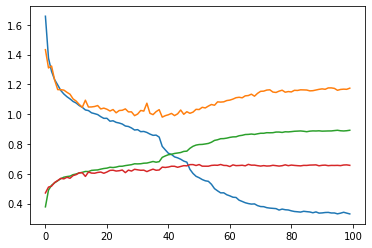

In [11]:
plt.plot(hist), best_acc

In [12]:
test_model = torch.load('featureactv4_omitHW_projconv_2facts_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.097 | Avg. val_acc: 0.658


In [ ]:
# precision, recall, f1 cal

predicted_classes = torch.argmax(y_pred, dim=1) == 0
target_classes = self.get_vector(y_batch)
target_true += torch.sum(target_classes == 0).float()
predicted_true += torch.sum(predicted_classes).float()
correct_true += torch.sum(
    predicted_classes == target_classes * predicted_classes == 0).float()


recall = correct_true / target_true
precision = correct_true / predicted_true
f1_score = 2 * precission * recall / (precision + recall)

## Omit D (not make sense much to me!)

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1, dropout=0.):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        
        self.dropout = nn.Dropout(dropout)
        
        self.layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        self.mid_layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        self.out_layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        
#         self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        self.norm_conv = nn.Sequential(nn.Linear(self.img_size*self.img_size, self.img_size*self.img_size),
                                       nn.Dropout(dropout))
        
        self.src_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(self.dim, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
        self.proj_conv = nn.Sequential(nn.Conv2d(self.src_depth, self.src_depth, kernel_size=1, padding=False),
                                       nn.ReLU())
        
    def forward(self, x):
        
        x_norm = self.layernorm(x)
        
        src_features = self.src_conv(x_norm)
        target_features = self.target_conv(x_norm)
        main_features = self.down_depth(x_norm)
        
        # cor has shape HWxHW
        cor = src_features.view(-1, self.dim, self.img_size * self.img_size).permute(0,2,1) \
                @ target_features.view(-1, self.dim, self.img_size*self.img_size)
        cor = cor / (math.sqrt(self.dim))
#         cor = self.att_act(cor)
        cor = self.dropout(cor) # additional dropout to prevent overfitting

        cor_feature = torch.cat([(main_features.view(-1, self.dim, self.img_size*self.img_size) \
                                  @ self.norm_conv(cor[:,:,k]).unsqueeze(-1)) \
                                   /math.sqrt(self.img_size*self.img_size) for k in range(self.img_size*self.img_size)], dim=2)
        cor_feature = cor_feature.view(-1, self.dim, self.img_size, self.img_size) # reshape to DxHxW
        cor_feature = self.up_depth(cor_feature)
        
        x_mid = x + cor_feature
        x_mid = self.mid_layernorm(x_mid)
        
        x_out = self.proj_conv(x_mid)
        x_out = x_out + x_mid
        x_out = self.out_layernorm(x_out)
        
        return x_out

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4, dropout=0.4)
        self.fact1 = FeatureAct(64, 12, 4, dropout=0.4)
        self.fact2 = FeatureAct(128, 6, 4, dropout=0.4)
        self.fact3 = FeatureAct(256, 3, 4, dropout=0.4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


### - norm

In [ ]:
model_path = './featureactv4_omitD_projconv_norm_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.2685425281524658 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [11:54<00:00,  3.18s/it]

- Avg.loss: 1.630 | Avg.acc: 0.391


- Avg. val_loss: 1.469 | Avg. val_acc: 0.464


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.1197158098220825 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [11:57<00:00,  3.19s/it]

- Avg.loss: 1.359 | Avg.acc: 0.498



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.264 | Avg. val_acc: 0.541
* Update optimal model
Epoch:  3


Loss=1.1727046966552734 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [11:55<00:00,  3.18s/it]

- Avg.loss: 1.268 | Avg.acc: 0.527



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.219 | Avg. val_acc: 0.550
* Update optimal model
Epoch:  4


Loss=1.3654037714004517 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [11:56<00:00,  3.18s/it]

- Avg.loss: 1.216 | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.172 | Avg. val_acc: 0.565
* Update optimal model
Epoch:  5


Loss=1.2090617418289185 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [11:55<00:00,  3.18s/it]

- Avg.loss: 1.175 | Avg.acc: 0.562



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.142 | Avg. val_acc: 0.570
* Update optimal model
Epoch:  6


Loss=1.1996277570724487 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [11:55<00:00,  3.18s/it]

- Avg.loss: 1.148 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.152 | Avg. val_acc: 0.571
* Update optimal model
Epoch:  7


Loss=1.2179021835327148 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [11:56<00:00,  3.18s/it]

- Avg.loss: 1.124 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103 | Avg. val_acc: 0.585
* Update optimal model
Epoch:  8


Loss=1.2100331783294678 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [11:55<00:00,  3.18s/it]

- Avg.loss: 1.107 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.093 | Avg. val_acc: 0.592
* Update optimal model
Epoch:  9


Loss=1.0493401288986206 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [11:56<00:00,  3.18s/it]

- Avg.loss: 1.089 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.592
Epoch:  10


Loss=1.345880389213562 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [11:56<00:00,  3.19s/it]

- Avg.loss: 1.074 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088 | Avg. val_acc: 0.600
* Update optimal model
Epoch:  11


Loss=0.7985544204711914 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [11:56<00:00,  3.18s/it]

- Avg.loss: 1.065 | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.574
Epoch:  12


Loss=1.2252240180969238 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [11:56<00:00,  3.18s/it]

- Avg.loss: 1.048 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084 | Avg. val_acc: 0.587
Epoch:  13


Loss=1.0631448030471802 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [11:55<00:00,  3.18s/it]

- Avg.loss: 1.039 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.075 | Avg. val_acc: 0.594
Epoch:  14


Loss=1.071927547454834 Batch_id=190 Accuracy=0.5859375:  85%|████████▍ | 191/225 [10:09<01:48,  3.18s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.9589035511016846 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [11:55<00:00,  3.18s/it]

- Avg.loss: 0.961 | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.621
Epoch:  22


Loss=1.039266586303711 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [11:56<00:00,  3.18s/it]

- Avg.loss: 0.953 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.615
Epoch:  23


Loss=1.5663807392120361 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [11:56<00:00,  3.18s/it]

- Avg.loss: 0.945 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.612
Epoch:  24


Loss=1.4205623865127563 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [11:56<00:00,  3.18s/it]

- Avg.loss: 0.939 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.607
Epoch:  25


Loss=0.744097113609314 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [11:56<00:00,  3.18s/it]

- Avg.loss: 0.926 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.624
* Update optimal model
Epoch:  26


Loss=0.7922788262367249 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [11:55<00:00,  3.18s/it]

- Avg.loss: 0.918 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.618
Epoch:  27


Loss=0.9581542015075684 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [11:56<00:00,  3.18s/it]

- Avg.loss: 0.916 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.622
Epoch:  28


Loss=0.9537132978439331 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [11:56<00:00,  3.18s/it]

- Avg.loss: 0.904 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.626
* Update optimal model
Epoch:  29


Loss=0.992028534412384 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [11:56<00:00,  3.18s/it]

- Avg.loss: 0.898 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.008 | Avg. val_acc: 0.616
Epoch:  30


Loss=0.783197283744812 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [11:55<00:00,  3.18s/it]

- Avg.loss: 0.892 | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.626
Epoch:  31


Loss=1.158500075340271 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [11:56<00:00,  3.18s/it]

- Avg.loss: 0.881 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033 | Avg. val_acc: 0.615
Epoch:  32


Loss=0.8767948746681213 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [11:55<00:00,  3.18s/it]

- Avg.loss: 0.880 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.618
Epoch:  33


Loss=1.228318452835083 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [11:54<00:00,  3.18s/it]

- Avg.loss: 0.866 | Avg.acc: 0.676



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.627
* Update optimal model
Epoch:  34


Loss=0.7710694074630737 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [11:54<00:00,  3.18s/it]

- Avg.loss: 0.866 | Avg.acc: 0.676



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.624
Epoch:  35


Loss=1.2234946489334106 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [11:55<00:00,  3.18s/it]

- Avg.loss: 0.861 | Avg.acc: 0.680



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.625
Epoch:  36


Loss=1.0050110816955566 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [11:56<00:00,  3.18s/it]

- Avg.loss: 0.848 | Avg.acc: 0.682



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.612
Epoch:  37


Loss=0.940577507019043 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [11:56<00:00,  3.18s/it]

- Avg.loss: 0.837 | Avg.acc: 0.687



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.621
Epoch:  38


Loss=0.80781489610672 Batch_id=51 Accuracy=0.703125:  23%|██▎       | 52/225 [02:47<09:10,  3.18s/it]   

([<matplotlib.lines.Line2D at 0x7f8e8975da90>,
 0.6475341320702146)

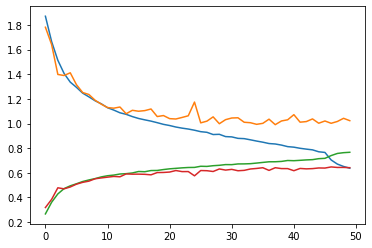

In [9]:
plt.plot(hist), best_acc

In [10]:
test_model = torch.load('featureactv4_omitD_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 0.986 | Avg. val_acc: 0.656


## Combined omit HW and D together

In [11]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1, dropout=0.):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        
        self.layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        self.mid_layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        self.out_layernorm = nn.LayerNorm((self.src_depth, self.img_size, self.img_size))
        
#         self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        self.norm_conv_d = nn.Sequential(nn.Dropout(dropout),
                                         nn.Linear(self.dim, self.dim))
        self.norm_conv_hw = nn.Sequential(nn.Dropout(dropout), 
                                          nn.Linear(self.img_size*self.img_size, self.img_size*self.img_size))
        
        self.src_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, self.dim, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(self.dim, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
        self.proj_conv = nn.Sequential(nn.Conv2d(self.src_depth, self.src_depth, kernel_size=1, padding=False),
                                       nn.ReLU())

        
    def forward(self, x):
        
        x_norm = self.layernorm(x)
        
        src_features = self.src_conv(x_norm)
        target_features = self.target_conv(x_norm)
        main_features = self.down_depth(x_norm)
        
        # cor has shape D x D
        cor_d = src_features.view(-1, self.dim, self.img_size * self.img_size) \
                @ target_features.view(-1, self.dim, self.img_size*self.img_size).permute(0, 2, 1)
        # scaled
        cor_d = cor_d / (math.sqrt(self.img_size * self.img_size))
        cor_feature_d = torch.cat([(main_features.view(-1, self.dim, self.img_size*self.img_size).permute(0,2,1) \
                                  @ self.norm_conv_d(cor_d[:,:,k]).unsqueeze(-1)).view(-1, 1, self.img_size, self.img_size) \
                                  /math.sqrt(self.dim)  for k in range(self.dim)], dim=1)
        
        # cor has shape HWxHW
        cor_hw = src_features.view(-1, self.dim, self.img_size * self.img_size).permute(0,2,1) \
                @ target_features.view(-1, self.dim, self.img_size*self.img_size)
        # scaled
        cor_hw = cor_hw / (math.sqrt(self.dim))
        cor_feature_hw = torch.cat([(main_features.view(-1, self.dim, self.img_size*self.img_size) \
                                  @ self.norm_conv_hw(cor_hw[:,:,k]).unsqueeze(-1)) \
                                  /math.sqrt(self.img_size*self.img_size) for k in range(self.img_size*self.img_size)], dim=2)
        cor_feature_hw = cor_feature_hw.view(-1, self.dim, self.img_size, self.img_size) # reshape to DxHxW
        
        cor_feature = cor_feature_d + cor_feature_hw
        cor_feature = self.up_depth(cor_feature)
    
        # projection
        x_mid = x + cor_feature
        x_mid = self.mid_layernorm(x_mid)
        
        x_out = self.proj_conv(x_mid)
        x_out = x_out + x_mid
        
        x_out = self.out_layernorm(x_out)
        
        return x_out

In [12]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4, dropout=0.4)
        self.fact1 = FeatureAct(64, 12, 4, dropout=0.4)
        self.fact2 = FeatureAct(128, 6, 4, dropout=0.4)
        self.fact3 = FeatureAct(256, 3, 4, dropout=0.4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [13]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv4_combinedomit_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.1575082540512085 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:00<00:00,  3.72it/s]

- Avg.loss: 1.627 | Avg.acc: 0.392



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.467 | Avg. val_acc: 0.461
* Update optimal model
Epoch:  2


Loss=1.6004480123519897 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:59<00:00,  3.75it/s]

- Avg.loss: 1.363 | Avg.acc: 0.497



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.378 | Avg. val_acc: 0.475
* Update optimal model
Epoch:  3


Loss=1.2941997051239014 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:00<00:00,  3.72it/s]

- Avg.loss: 1.274 | Avg.acc: 0.521



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.276 | Avg. val_acc: 0.521
* Update optimal model
Epoch:  4


Loss=1.048546552658081 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:00<00:00,  3.73it/s]

- Avg.loss: 1.214 | Avg.acc: 0.547



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.245 | Avg. val_acc: 0.534
* Update optimal model
Epoch:  5


Loss=1.1601816415786743 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:00<00:00,  3.74it/s]

- Avg.loss: 1.182 | Avg.acc: 0.559



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.181 | Avg. val_acc: 0.550
* Update optimal model
Epoch:  6


Loss=1.3056477308273315 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:00<00:00,  3.72it/s]

- Avg.loss: 1.150 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.196 | Avg. val_acc: 0.557
* Update optimal model
Epoch:  7


Loss=0.9844781160354614 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:00<00:00,  3.72it/s]

- Avg.loss: 1.122 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.110 | Avg. val_acc: 0.580
* Update optimal model
Epoch:  8


Loss=1.2958753108978271 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:00<00:00,  3.70it/s]

- Avg.loss: 1.103 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103 | Avg. val_acc: 0.588
* Update optimal model
Epoch:  9


Loss=1.4998605251312256 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:00<00:00,  3.74it/s]

- Avg.loss: 1.083 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.162 | Avg. val_acc: 0.567
Epoch:  10


Loss=0.7789310216903687 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:00<00:00,  3.73it/s]

- Avg.loss: 1.064 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.571
Epoch:  11


Loss=0.823199450969696 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:00<00:00,  3.70it/s]

- Avg.loss: 1.058 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.108 | Avg. val_acc: 0.579
Epoch:  12


Loss=1.2323014736175537 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:59<00:00,  3.75it/s]

- Avg.loss: 1.037 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.596
* Update optimal model
Epoch:  13


Loss=0.9572147727012634 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:00<00:00,  3.71it/s]

- Avg.loss: 1.029 | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.615
* Update optimal model
Epoch:  14


Loss=1.0155816078186035 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:00<00:00,  3.74it/s]

- Avg.loss: 1.006 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.615
* Update optimal model
Epoch:  15


Loss=1.3163862228393555 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:00<00:00,  3.73it/s]

- Avg.loss: 1.003 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.612
Epoch:  16


Loss=1.227285385131836 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:00<00:00,  3.74it/s]

- Avg.loss: 0.991 | Avg.acc: 0.627



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.609
Epoch:  17


Loss=0.8135039210319519 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:00<00:00,  3.74it/s]

- Avg.loss: 0.982 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.109 | Avg. val_acc: 0.589
Epoch:  18


Loss=0.7182631492614746 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:00<00:00,  3.73it/s]

- Avg.loss: 0.968 | Avg.acc: 0.636



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.055 | Avg. val_acc: 0.612
Epoch:  19


Loss=0.9438077807426453 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:00<00:00,  3.74it/s]

- Avg.loss: 0.956 | Avg.acc: 0.640



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.164 | Avg. val_acc: 0.583
Epoch:  20


Loss=0.951714277267456 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:00<00:00,  3.72it/s]

- Avg.loss: 0.954 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.062 | Avg. val_acc: 0.601
Epoch:  21


Loss=1.0192006826400757 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:00<00:00,  3.72it/s]

- Avg.loss: 0.945 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.043 | Avg. val_acc: 0.617
* Update optimal model
Epoch:  22


Loss=0.9777080416679382 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:00<00:00,  3.69it/s]

- Avg.loss: 0.936 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.622
Epoch    22: reducing learning rate of group 0 to 5.0000e-04.
* Update optimal model
Epoch:  23


Loss=0.9757550954818726 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:00<00:00,  3.73it/s]

- Avg.loss: 0.873 | Avg.acc: 0.674



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.640
* Update optimal model
Epoch:  24


Loss=0.7785382270812988 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:00<00:00,  3.72it/s]

- Avg.loss: 0.850 | Avg.acc: 0.682



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.641
* Update optimal model
Epoch:  25


Loss=0.8333737850189209 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:00<00:00,  3.69it/s]

- Avg.loss: 0.839 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.978 | Avg. val_acc: 0.632
Epoch:  26


Loss=1.1572811603546143 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:00<00:00,  3.73it/s]

- Avg.loss: 0.813 | Avg.acc: 0.702



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.644
* Update optimal model
Epoch:  28


Loss=0.9454773664474487 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:00<00:00,  3.73it/s]

- Avg.loss: 0.801 | Avg.acc: 0.707



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.645
* Update optimal model
Epoch:  29


Loss=0.9798647165298462 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:59<00:00,  3.76it/s]

- Avg.loss: 0.794 | Avg.acc: 0.704



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.639
Epoch:  30


Loss=0.9588804244995117 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:00<00:00,  3.73it/s]

- Avg.loss: 0.781 | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.642
Epoch:  31


Loss=0.9386705756187439 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:59<00:00,  3.76it/s]

- Avg.loss: 0.772 | Avg.acc: 0.716



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.976 | Avg. val_acc: 0.656
* Update optimal model
Epoch:  32


Loss=0.9867101907730103 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:59<00:00,  3.76it/s]

- Avg.loss: 0.756 | Avg.acc: 0.721



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.636
Epoch    32: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  33


Loss=0.8945596218109131 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:00<00:00,  3.71it/s]

- Avg.loss: 0.709 | Avg.acc: 0.740



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.970 | Avg. val_acc: 0.646
Epoch:  34


Loss=0.5671705603599548 Batch_id=111 Accuracy=0.8359375:  49%|████▉     | 111/225 [00:30<00:29,  3.83it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.654
Epoch:  42


Loss=0.7889882922172546 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:59<00:00,  3.76it/s]

- Avg.loss: 0.580 | Avg.acc: 0.794



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.656
Epoch    42: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  43


Loss=0.6243341565132141 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:00<00:00,  3.74it/s]

- Avg.loss: 0.514 | Avg.acc: 0.821



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.657
Epoch:  46


Loss=0.578452467918396 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:00<00:00,  3.74it/s]

- Avg.loss: 0.511 | Avg.acc: 0.819



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047 | Avg. val_acc: 0.656
Epoch:  47


Loss=0.7292656898498535 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:59<00:00,  3.76it/s]

- Avg.loss: 0.500 | Avg.acc: 0.828



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.049 | Avg. val_acc: 0.662
* Update optimal model
Epoch:  48


Loss=0.6957006454467773 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:00<00:00,  3.74it/s]

- Avg.loss: 0.496 | Avg.acc: 0.828



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.660
Epoch:  49


Loss=0.8573781847953796 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:00<00:00,  3.73it/s]

- Avg.loss: 0.480 | Avg.acc: 0.834



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.666
* Update optimal model
Epoch:  50


Loss=0.5062563419342041 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [01:00<00:00,  3.71it/s]

- Avg.loss: 0.478 | Avg.acc: 0.834



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.049 | Avg. val_acc: 0.658
Epoch    50: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  51


Loss=0.5182539820671082 Batch_id=152 Accuracy=0.8515625:  68%|██████▊   | 153/225 [00:42<00:19,  3.79it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.46178746223449707 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [01:00<00:00,  3.71it/s]

- Avg.loss: 0.392 | Avg.acc: 0.868



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088 | Avg. val_acc: 0.664
Epoch:  62


Loss=0.4188009202480316 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [01:00<00:00,  3.71it/s]

- Avg.loss: 0.389 | Avg.acc: 0.870



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.094 | Avg. val_acc: 0.658
Epoch:  63


Loss=0.45125967264175415 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [01:00<00:00,  3.73it/s]

- Avg.loss: 0.383 | Avg.acc: 0.873



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.101 | Avg. val_acc: 0.661
Epoch:  64


Loss=0.2722867429256439 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [01:00<00:00,  3.73it/s]

- Avg.loss: 0.381 | Avg.acc: 0.875



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.094 | Avg. val_acc: 0.659
Epoch:  65


Loss=0.748255729675293 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:00<00:00,  3.75it/s]

- Avg.loss: 0.380 | Avg.acc: 0.873



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.109 | Avg. val_acc: 0.659
Epoch:  66


Loss=0.7189468145370483 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:00<00:00,  3.72it/s]

- Avg.loss: 0.379 | Avg.acc: 0.875



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.108 | Avg. val_acc: 0.657
Epoch    66: reducing learning rate of group 0 to 1.5625e-05.
Epoch:  67


Loss=0.7099298238754272 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:00<00:00,  3.74it/s]

- Avg.loss: 0.373 | Avg.acc: 0.878



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.661
Epoch:  68


Loss=0.3457387089729309 Batch_id=17 Accuracy=0.890625:   8%|▊         | 17/225 [00:06<00:55,  3.77it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.2152712196111679 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [01:00<00:00,  3.73it/s]

- Avg.loss: 0.348 | Avg.acc: 0.887



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.111 | Avg. val_acc: 0.660
Epoch:  87


Loss=0.48550528287887573 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [01:00<00:00,  3.71it/s]

- Avg.loss: 0.350 | Avg.acc: 0.886



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.106 | Avg. val_acc: 0.659
Epoch:  88


Loss=0.20322400331497192 Batch_id=224 Accuracy=0.972972972972973: 100%|██████████| 225/225 [01:00<00:00,  3.70it/s]

- Avg.loss: 0.347 | Avg.acc: 0.887



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.118 | Avg. val_acc: 0.660
Epoch:  89


Loss=0.4454002380371094 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [01:00<00:00,  3.72it/s]

- Avg.loss: 0.348 | Avg.acc: 0.887



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114 | Avg. val_acc: 0.657
Epoch:  90


Loss=0.43620577454566956 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [01:00<00:00,  3.73it/s]

- Avg.loss: 0.346 | Avg.acc: 0.891



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114 | Avg. val_acc: 0.659
Epoch    90: reducing learning rate of group 0 to 1.9531e-06.
Epoch:  91


Loss=0.579918384552002 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:59<00:00,  3.76it/s]

- Avg.loss: 0.345 | Avg.acc: 0.890



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.110 | Avg. val_acc: 0.662
Epoch:  92


Loss=0.24935679137706757 Batch_id=176 Accuracy=0.9296875:  78%|███████▊  | 176/225 [00:48<00:12,  3.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



([<matplotlib.lines.Line2D at 0x7f3bc07f9908>,
 0.6464196154917804)

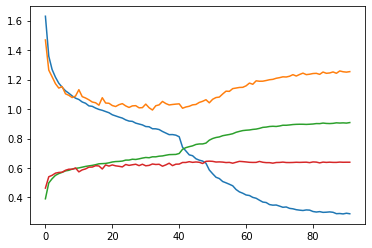

In [9]:
plt.plot(hist), best_acc

In [14]:
test_model = torch.load('featureactv4_combinedomit_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

ModuleAttributeError: 'FeatureAct' object has no attribute 'mid_layernorm'